In [1]:
from imblearn.metrics import geometric_mean_score
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
np.random.seed(13)
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from __future__ import division
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize

files=['AAPL','AMZN','PEP','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','BKNG','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
#files=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
  
prices=list()
sentiment=list()
for file in files:
    param = {
        'q': file, # Stock symbol (ex: "AAPL")
        'i': "900", # Interval size in seconds ("86400" = 1 day intervals)
        'x': "NASD", # INDEXNASDAQStock exchange symbol on which stock is traded (ex: "NASD")
        'p': "2Y" # Period (Ex: "1Y" = 1 year)
        }
    sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/intrinioDatasetUpdated/Sentiment/'+file+'.csv')
    price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDatasetUpdated/'+file+'.csv')
    #sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalSentiment/'+file+'.csv')
    #price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDataset/indexes'+file+'.csv')
    #alignment of data
    maxdata=max(sentimentVector['initTime'])
    mindata=min(sentimentVector['initTime'])
    price['Unnamed: 0'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['Unnamed: 0']]
    price['Unnamed: 0'] = [row-timedelta(hours=8) for row in price['Unnamed: 0']]
    price=price[price['Unnamed: 0']>=mindata]
    price=price[price['Unnamed: 0']<=maxdata]
    print(file)
    sentimentVector=sentimentVector.drop(['Unnamed: 0', 'initTime' ], axis=1)
    meanvector=np.concatenate((sentimentVector,sentimentVector.rolling(5).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(10).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(15).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(20).mean()),axis=1)
    price=price.drop(['Unnamed: 0'],axis=1)
    #['macd','macds', 'boll_ub', 'boll_lb','rsi_6','rsi_12','vr_6_sma','wr_10','wr_6''close_10_sma''tr''middle_{}_sma'
    #df['dma'] = df['close_10_sma'] - df['close_50_sma'] pdi'] = cls._get_pdi(df, 14)df['mdi'] = cls._get_mdi(df, 14)
    #df['dx'] = cls._get_dx(df, 14) df['adx'] = df['dx_6_ema'] df['adxr'] = df['adx_6_ema']]
    #
    sentiment.append(meanvector)
    prices.append(price)

/home/andrea/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


AAPL
AMZN
PEP
GOOGL
MSFT
FB
INTC
CSCO
CMCSA
NVDA
NFLX
BKNG
ADBE
AMGN
TXN
AVGO
PYPL
GILD
COST
QCOM


In [2]:
def smote(x,y):
    
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled
def balance(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    nindex=min(len(posindex[0]),len(negindex[0]))

    #for i in range(1,nindex):
    yt=np.concatenate((y[posindex[0][0:nindex]],y[negindex[0][0:nindex]]))
    xt=np.concatenate((x[posindex[0][0:nindex]],x[negindex[0][0:nindex]]))
    
    return xt,yt

def balanceup(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    
    if(len(posindex[0])!=0 and len(negindex[0])!=0):
       
        nindex=max(len(posindex[0]),len(negindex[0]))
        mini=min(len(posindex[0]),len(negindex[0]))
        diff=nindex-mini
        u=0
        for i in range(0,mini):
            yt.append(y[posindex[0][i]])
            yt.append(y[negindex[0][i]])
            xt.append(x[posindex[0][i]])
            xt.append(x[negindex[0][i]])
        #print('first',sum(yt)/len(yt)) 
        if(len(posindex[0])>len(negindex[0])):
            toextract=negindex
            enter=posindex
        else:
            toextract=posindex
            enter=negindex
        if(diff!=0 and len(toextract[0])!=0):
            for i in range(0,diff):
                r=np.random.randint(0,len(toextract))
                yt.append(y[toextract[0][r]])
                xt.append(x[toextract[0][r]])
                yt.append(y[enter[0][mini+i]])
                xt.append(x[enter[0][mini+i]])
    else:
        #print('Unbalance')
        u=1
        xt=x
        yt=y
    #print(sum(yt)/len(yt))              
    return xt,yt,u
                    

In [3]:
def buildModel(l,n,d,le):
    opt=optimizers.Adam(lr=le)
    model = Sequential()  
    model.add(Dense(n, input_dim=151,activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/2), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/4), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(3, activation='softmax')) 
    
    model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

    return model
def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
def toOneHot(y):
    yhot=[]
    for i in range(0,len(y)):
        if(y[i]==1):
            yhot.append([0,0,1])
        elif(y[i]==-1):
            yhot.append([1,0,0])
        elif(y[i]==0):
            yhot.append([0,1,0])
        else:
            print('Problem in hot vector')
    return yhot


Working on... AAPL
15.571701720841297
0.005338458253266777
working on d,u and l,le 0.5 64 0.05 0.001


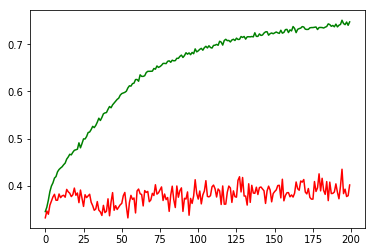

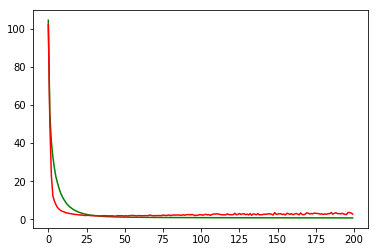

working on d,u and l,le 0.5 64 0.05 0.0001


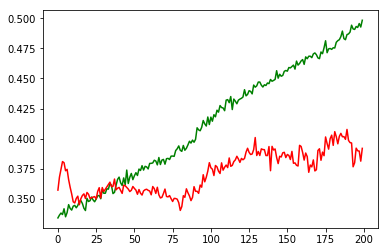

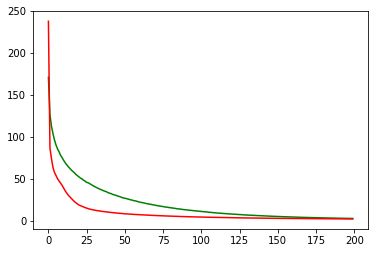

working on d,u and l,le 0.5 128 0.05 0.001


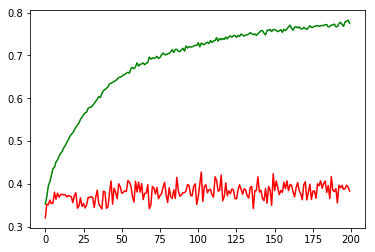

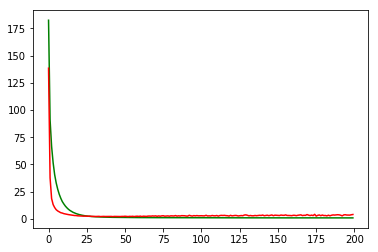

working on d,u and l,le 0.5 128 0.05 0.0001


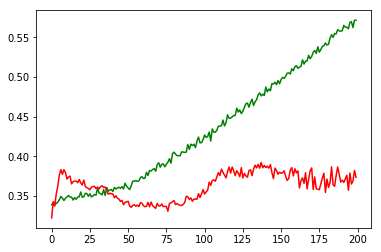

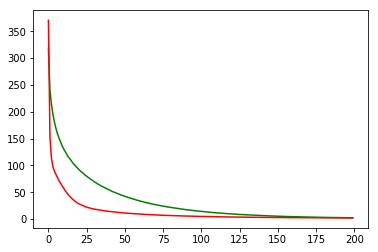

working on d,u and l,le 0.5 256 0.05 0.001


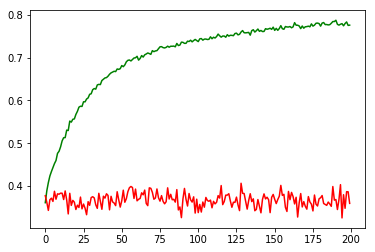

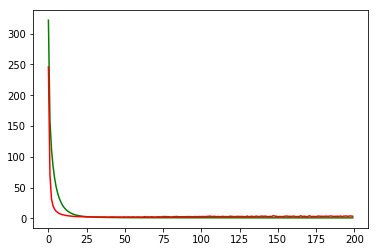

working on d,u and l,le 0.5 256 0.05 0.0001


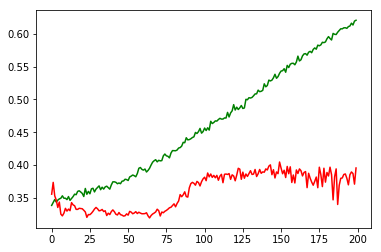

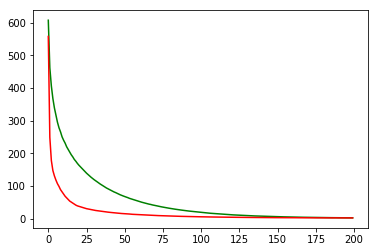

best model u,l,d,learn 0.05 64 0.5 0.001
Chart for BEST MODEL FOR: AAPL


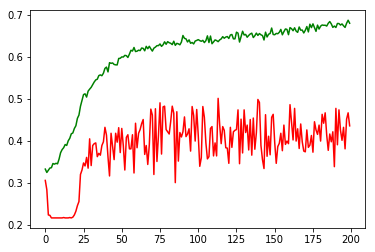

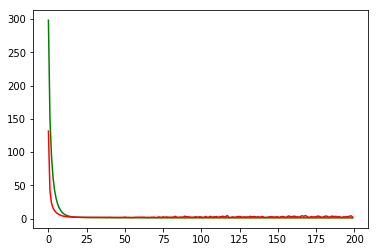

G-score: 0.5396215883540836
Accuracy 0.4353982319874046
0.4353982300884956
Window: 140
[[255  65  49]
 [155  29  60]
 [186 123 208]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... AMZN
11.150617492631287
0.0007590184265374819
working on d,u and l,le 0.5 64 0.05 0.001


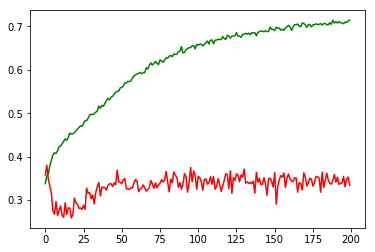

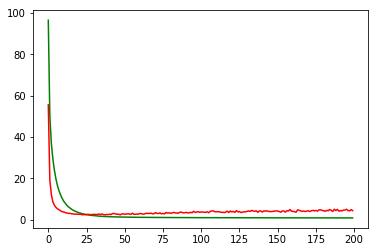

working on d,u and l,le 0.5 64 0.05 0.0001


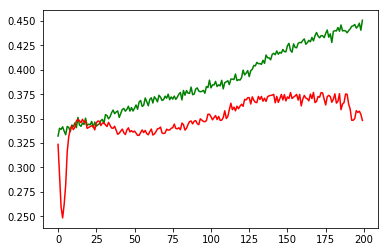

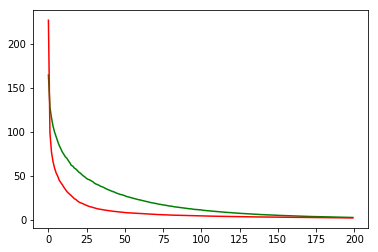

working on d,u and l,le 0.5 128 0.05 0.001


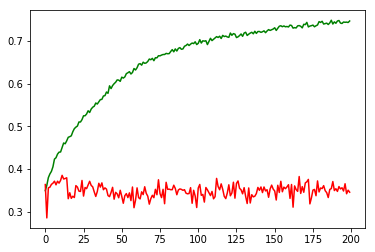

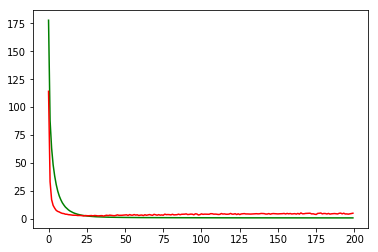

working on d,u and l,le 0.5 128 0.05 0.0001


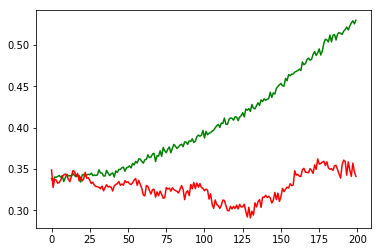

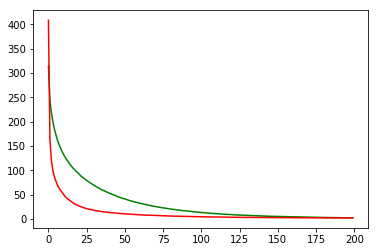

working on d,u and l,le 0.5 256 0.05 0.001


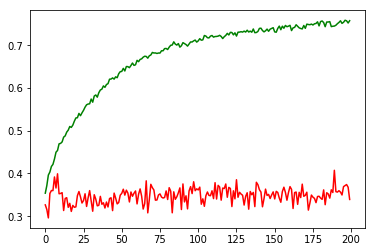

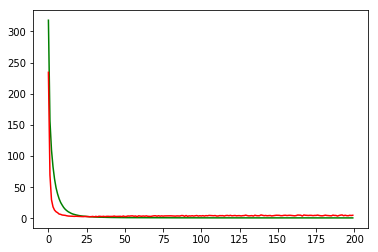

working on d,u and l,le 0.5 256 0.05 0.0001


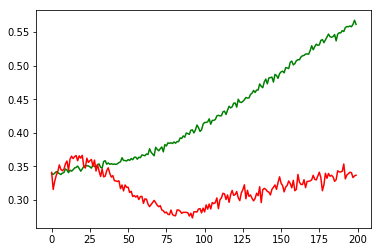

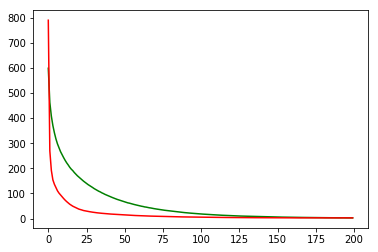

best model u,l,d,learn 0.05 128 0.5 0.0001
Chart for BEST MODEL FOR: AMZN


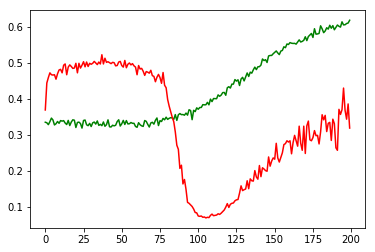

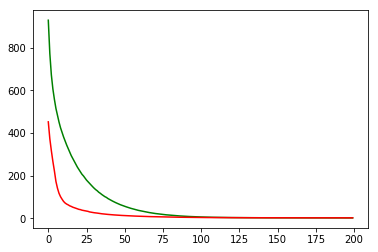

G-score: 0.4413767189363397
Accuracy 0.31890459237587326
0.31890459363957596
Window: 140
[[ 14   1  53]
 [236  82 222]
 [192  67 265]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... PEP
5.495274763738178
0.0
working on d,u and l,le 0.5 64 0.05 0.001


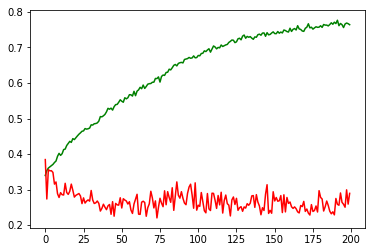

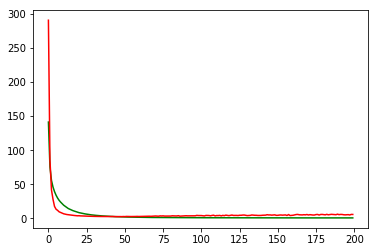

working on d,u and l,le 0.5 64 0.05 0.0001


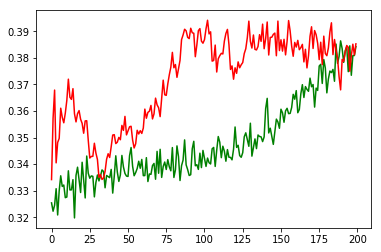

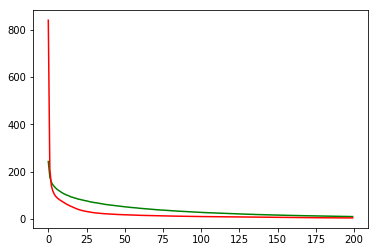

working on d,u and l,le 0.5 128 0.05 0.001


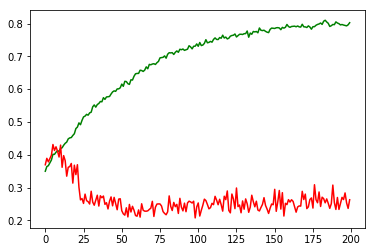

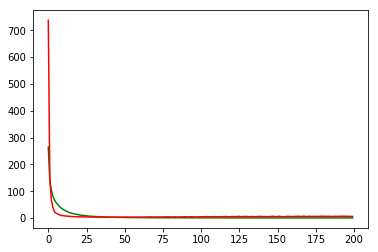

working on d,u and l,le 0.5 128 0.05 0.0001


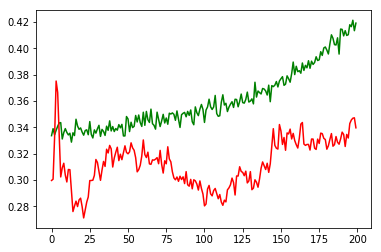

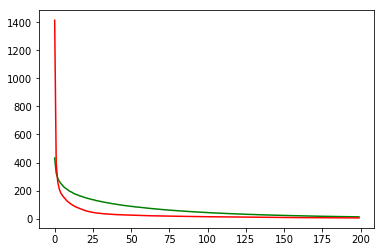

working on d,u and l,le 0.5 256 0.05 0.001


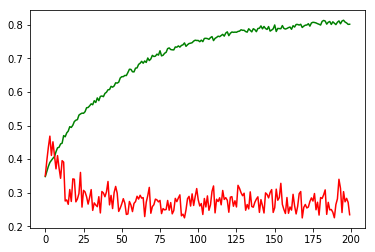

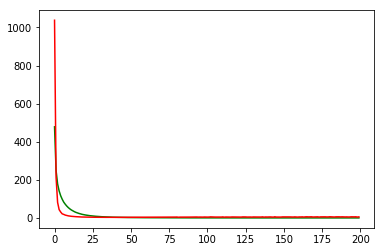

working on d,u and l,le 0.5 256 0.05 0.0001


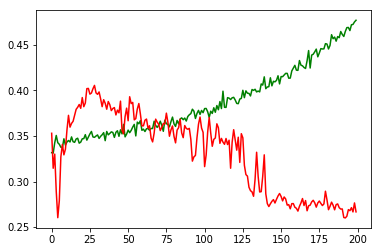

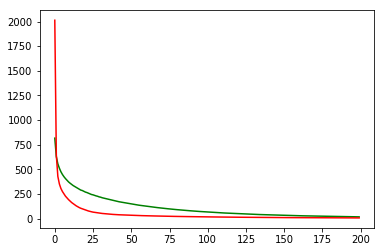

best model u,l,d,learn 0.05 64 0.5 0.0001
Chart for BEST MODEL FOR: PEP


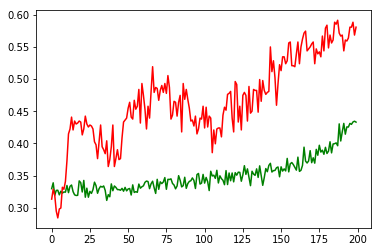

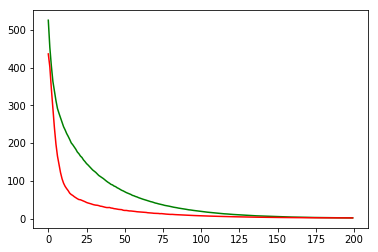

G-score: 0.5721784567523354
Accuracy 0.5806451613361019
0.5806451612903226
Window: 140
[[  6  24   5]
 [ 28  69  51]
 [ 55 110 303]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... GOOGL
9.280622946926826
0.003477111910863453
working on d,u and l,le 0.5 64 0.05 0.001


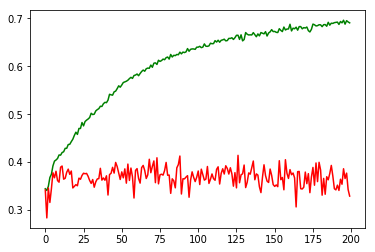

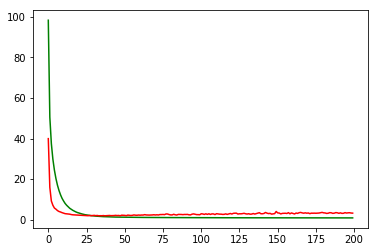

working on d,u and l,le 0.5 64 0.05 0.0001


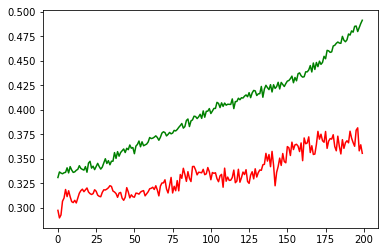

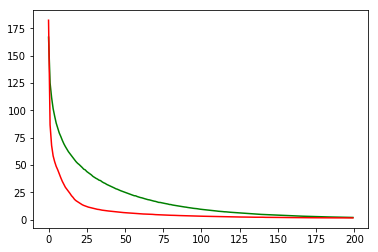

working on d,u and l,le 0.5 128 0.05 0.001


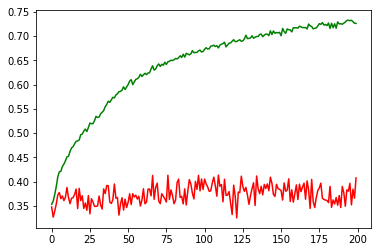

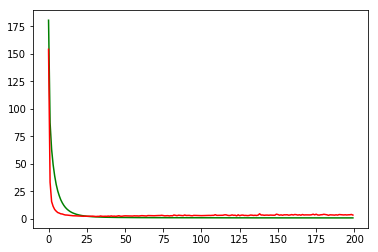

working on d,u and l,le 0.5 128 0.05 0.0001


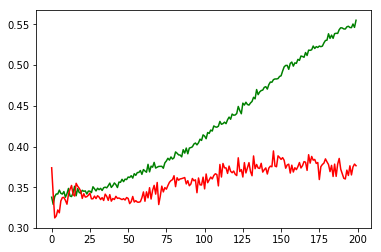

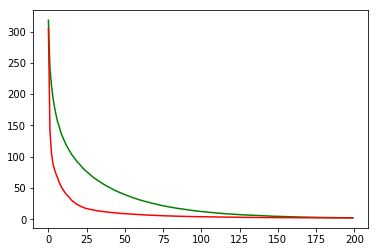

working on d,u and l,le 0.5 256 0.05 0.001


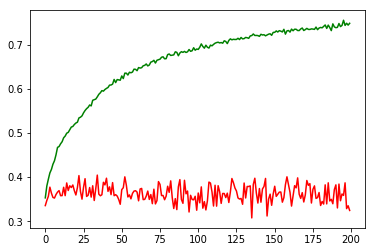

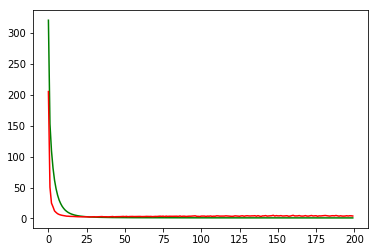

working on d,u and l,le 0.5 256 0.05 0.0001


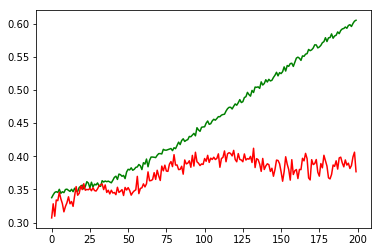

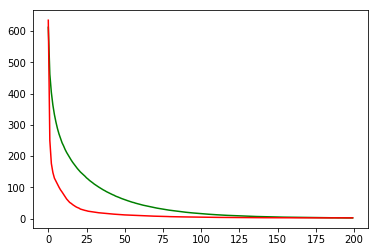

best model u,l,d,learn 0.05 128 0.5 0.001
Chart for BEST MODEL FOR: GOOGL


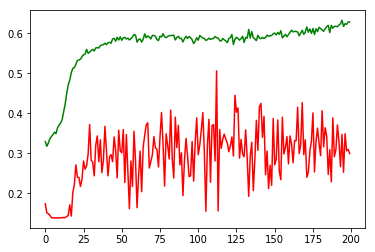

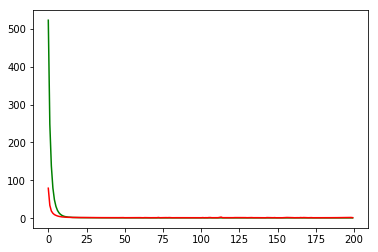

G-score: 0.45745489791258753
Accuracy 0.29911504435328257
0.2991150442477876
Window: 140
[[110 115 136]
 [ 64  58  34]
 [148 295 170]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... MSFT
5.843279709392834
0.0
working on d,u and l,le 0.5 64 0.05 0.001


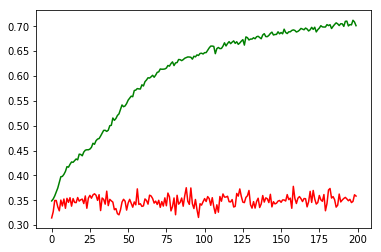

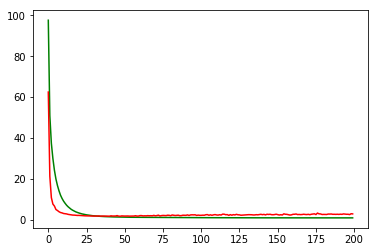

working on d,u and l,le 0.5 64 0.05 0.0001


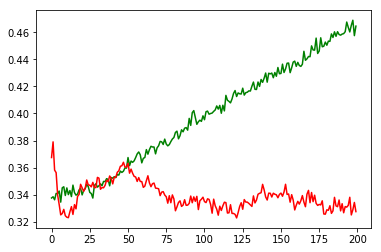

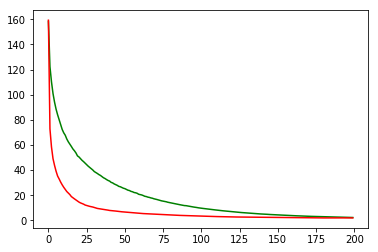

working on d,u and l,le 0.5 128 0.05 0.001


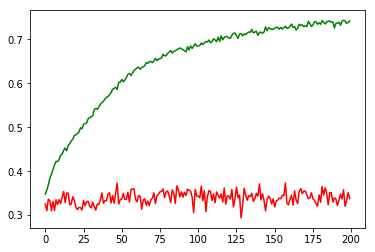

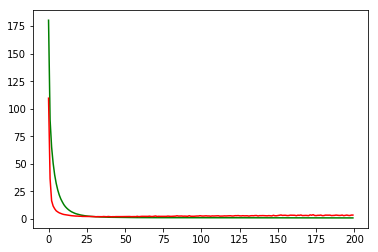

working on d,u and l,le 0.5 128 0.05 0.0001


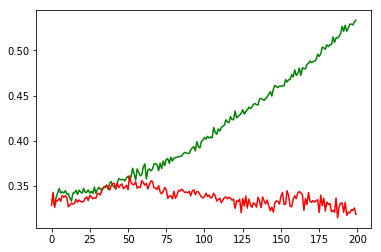

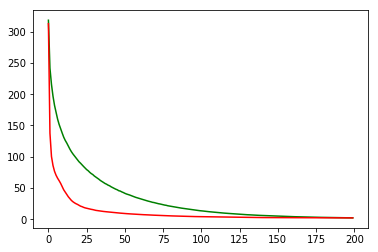

working on d,u and l,le 0.5 256 0.05 0.001


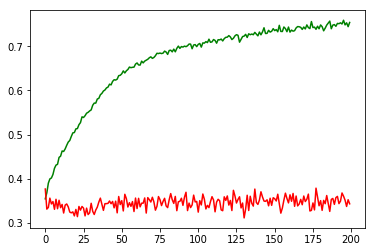

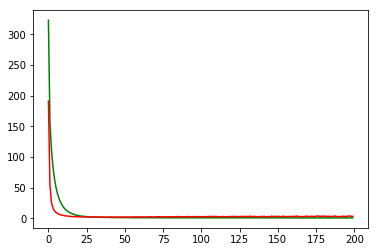

working on d,u and l,le 0.5 256 0.05 0.0001


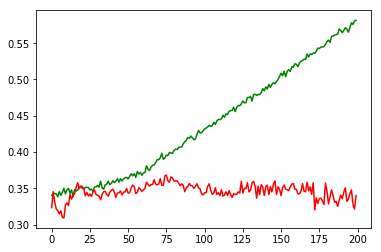

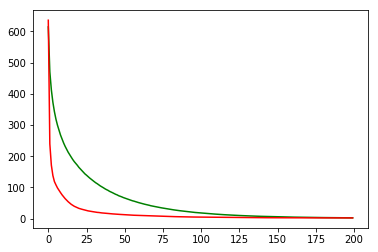

best model u,l,d,learn 0.05 64 0.5 0.001
Chart for BEST MODEL FOR: MSFT


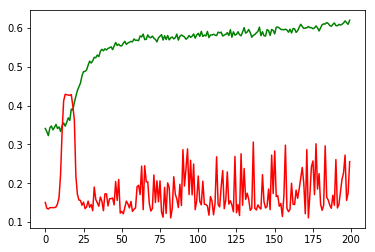

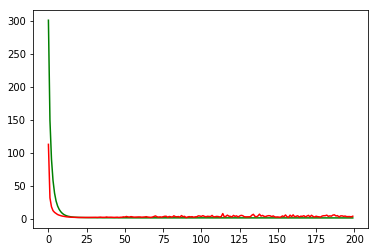

G-score: 0.41568146018774016
Accuracy 0.2557522118882795
0.2557522123893805
Window: 140
[[ 48  18  89]
 [236  27 219]
 [248  31 214]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... FB
12.871078806426938
0.005182421227207363
working on d,u and l,le 0.5 64 0.05 0.001


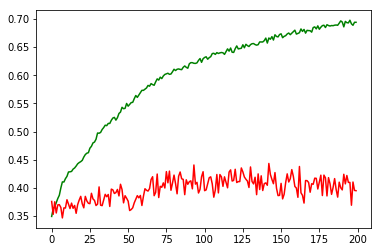

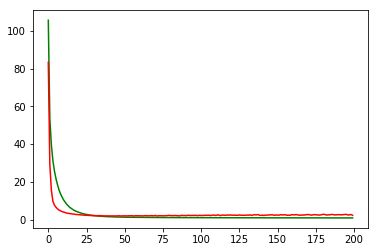

working on d,u and l,le 0.5 64 0.05 0.0001


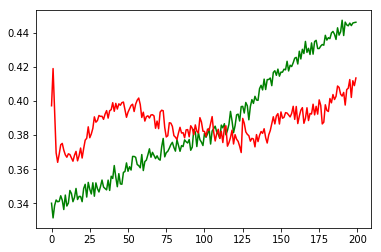

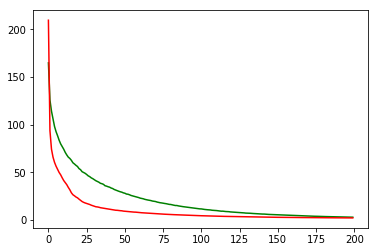

working on d,u and l,le 0.5 128 0.05 0.001


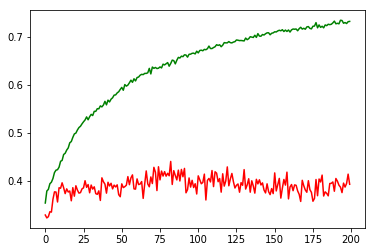

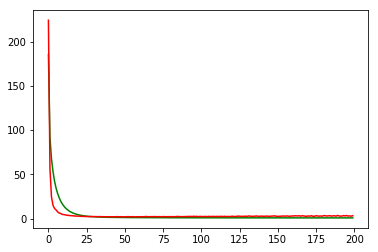

working on d,u and l,le 0.5 128 0.05 0.0001


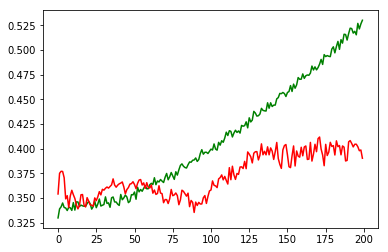

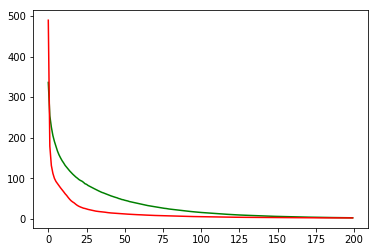

working on d,u and l,le 0.5 256 0.05 0.001


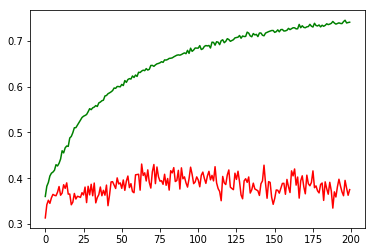

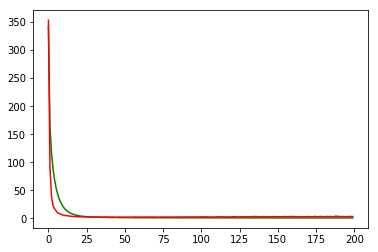

working on d,u and l,le 0.5 256 0.05 0.0001


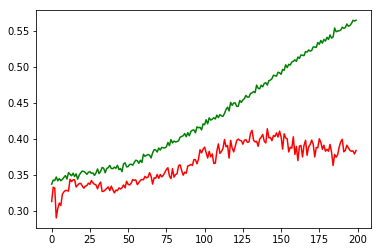

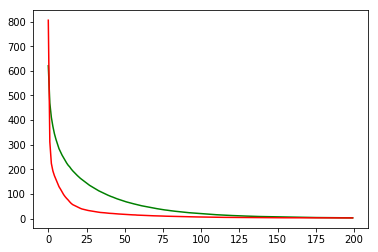

best model u,l,d,learn 0.05 64 0.5 0.0001
Chart for BEST MODEL FOR: FB


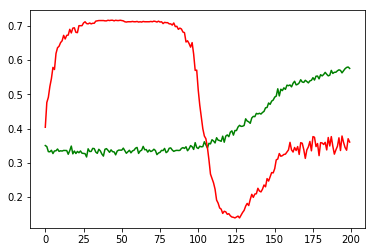

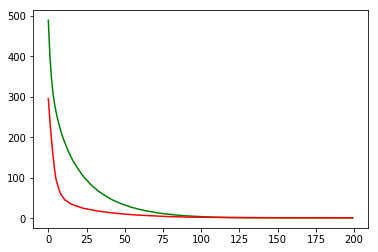

G-score: 0.5351016199871855
Accuracy 0.36042402826855124
0.36042402826855124
Window: 140
[[129  56  31]
 [ 46  33  27]
 [338 226 246]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... INTC
6.746031746031759
0.009064539521396952
working on d,u and l,le 0.5 64 0.05 0.001


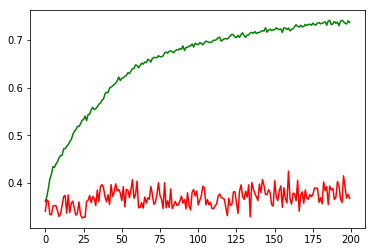

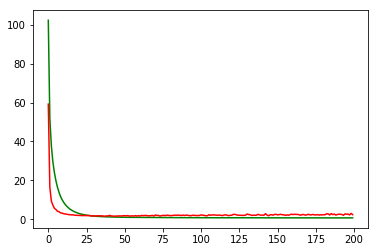

working on d,u and l,le 0.5 64 0.05 0.0001


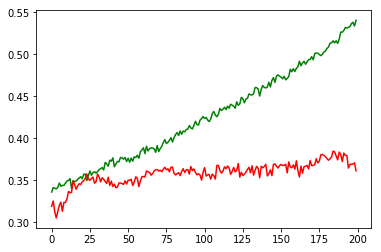

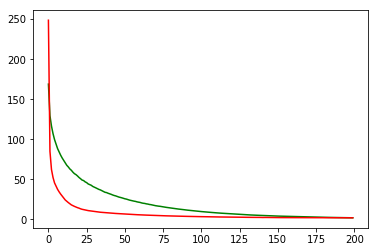

working on d,u and l,le 0.5 128 0.05 0.001


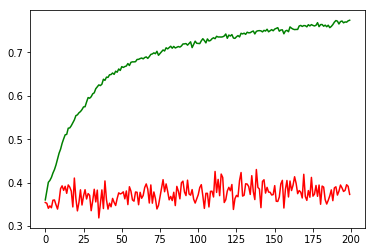

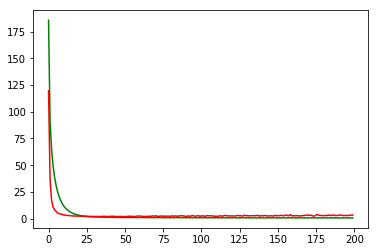

working on d,u and l,le 0.5 128 0.05 0.0001


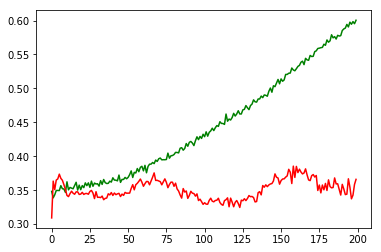

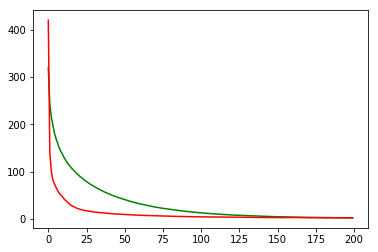

working on d,u and l,le 0.5 256 0.05 0.001


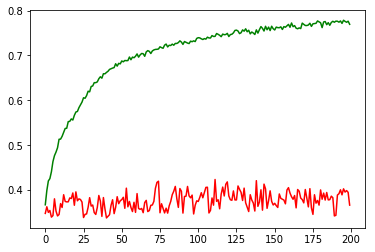

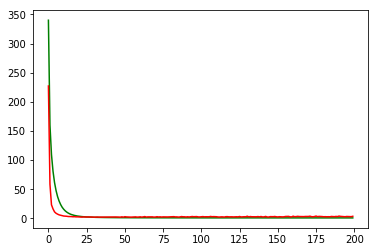

working on d,u and l,le 0.5 256 0.05 0.0001


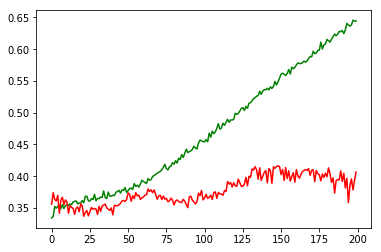

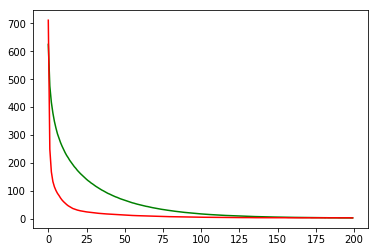

best model u,l,d,learn 0.05 256 0.5 0.0001
Chart for BEST MODEL FOR: INTC


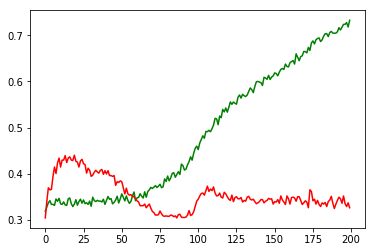

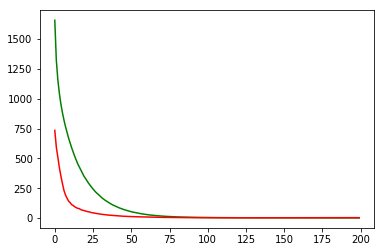

G-score: 0.49343548952432165
Accuracy 0.3259717287107407
0.32597173144876324
Window: 140
[[316  10   7]
 [329  11  14]
 [377  26  42]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... CSCO
6.455652128779988
0.0
working on d,u and l,le 0.5 64 0.05 0.001
Non balance


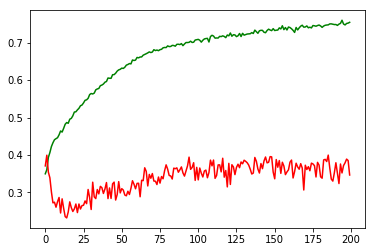

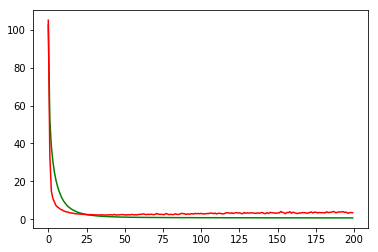

working on d,u and l,le 0.5 64 0.05 0.0001
Non balance


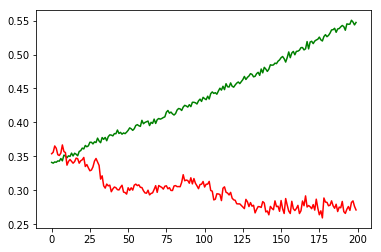

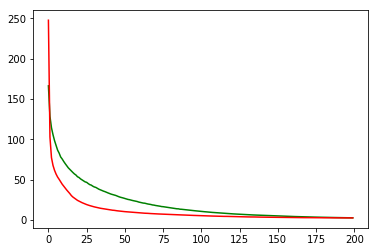

working on d,u and l,le 0.5 128 0.05 0.001
Non balance


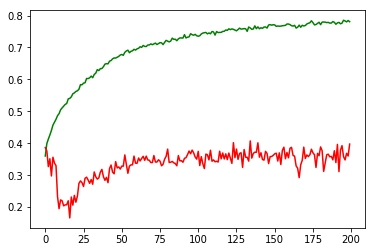

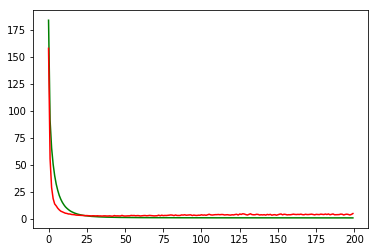

working on d,u and l,le 0.5 128 0.05 0.0001
Non balance


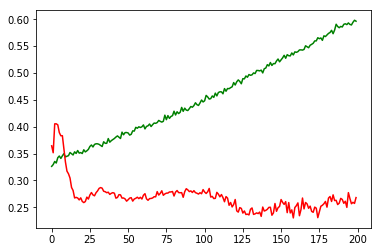

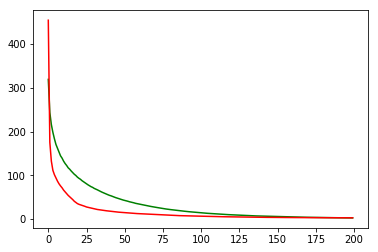

working on d,u and l,le 0.5 256 0.05 0.001
Non balance


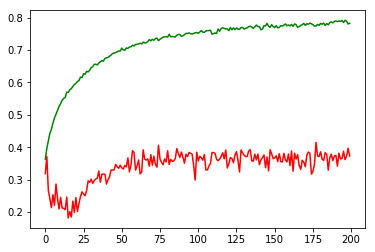

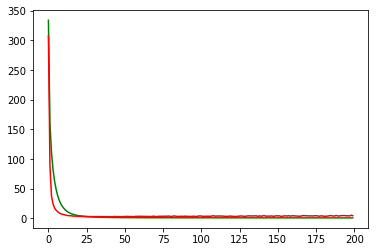

working on d,u and l,le 0.5 256 0.05 0.0001
Non balance


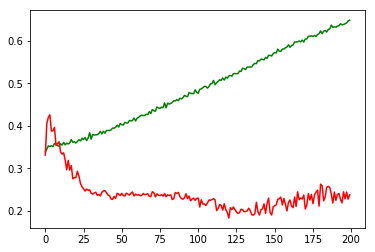

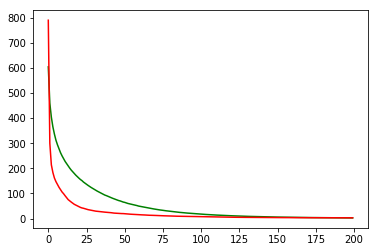

best model u,l,d,learn 0.05 128 0.5 0.001
Chart for BEST MODEL FOR: CSCO


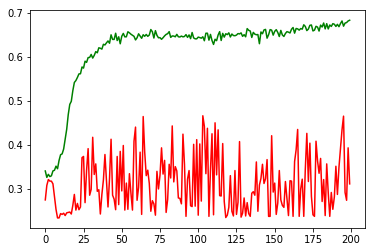

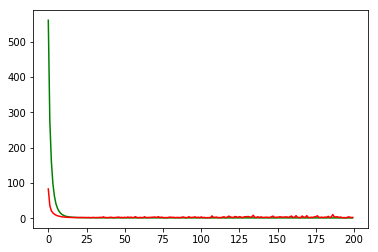

G-score: 0.5030868658864734
Accuracy 0.3111111114554935
0.3111111111111111
Window: 140
[[228  21  18]
 [370 106  25]
 [272  69  16]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... CMCSA
10.63829787234043
0.0
working on d,u and l,le 0.5 64 0.05 0.001


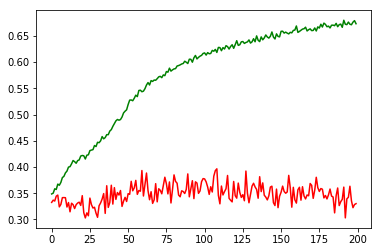

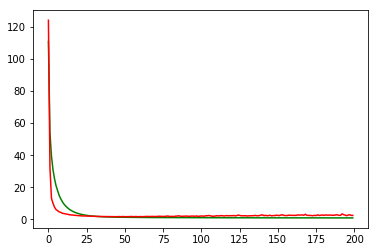

working on d,u and l,le 0.5 64 0.05 0.0001


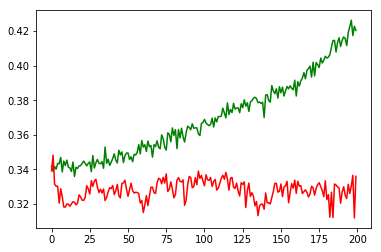

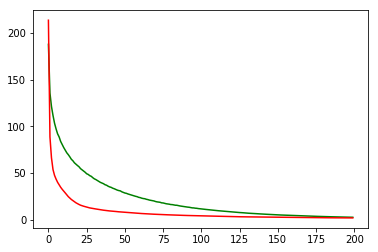

working on d,u and l,le 0.5 128 0.05 0.001


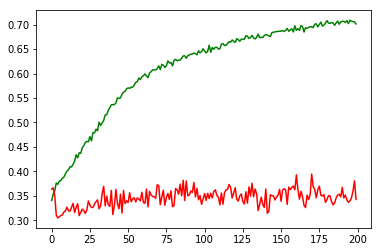

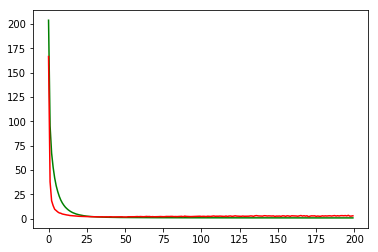

working on d,u and l,le 0.5 128 0.05 0.0001


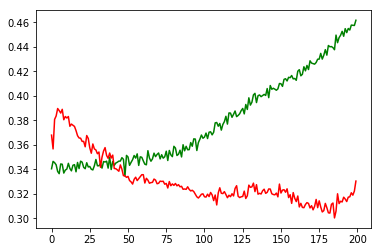

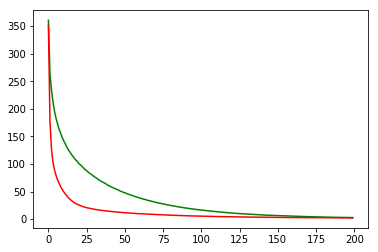

working on d,u and l,le 0.5 256 0.05 0.001


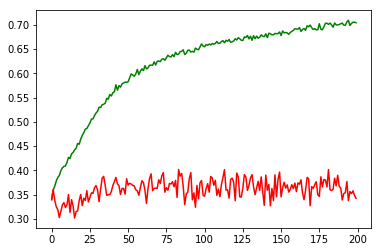

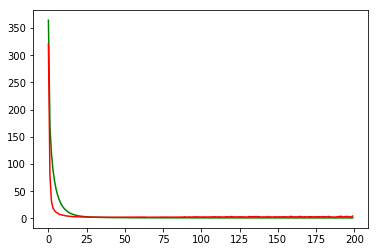

working on d,u and l,le 0.5 256 0.05 0.0001


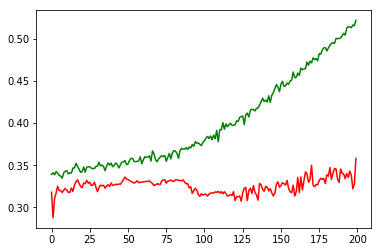

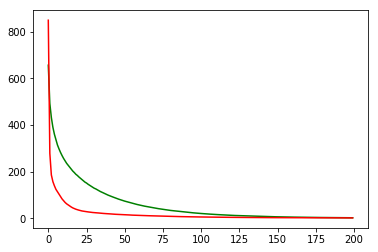

best model u,l,d,learn 0.05 256 0.5 0.0001
Chart for BEST MODEL FOR: CMCSA


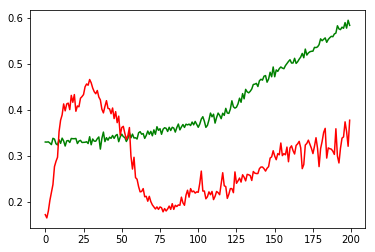

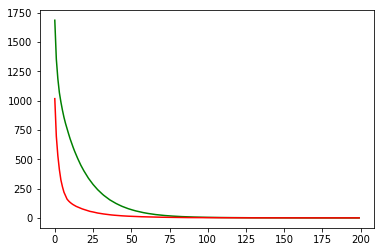

G-score: 0.47820103352133114
Accuracy 0.37720848056537104
0.37720848056537104
Window: 140
[[ 64  88 280]
 [ 32  51 104]
 [ 76 125 312]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... NVDA
14.360220994475142
0.0
working on d,u and l,le 0.5 64 0.05 0.001


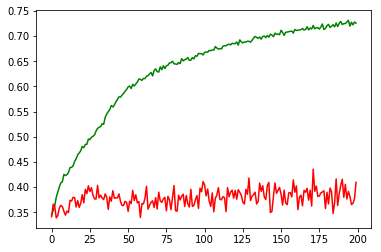

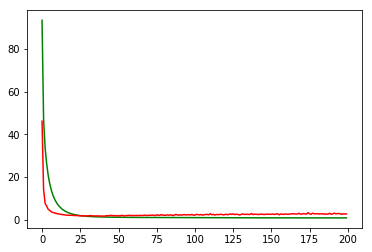

working on d,u and l,le 0.5 64 0.05 0.0001


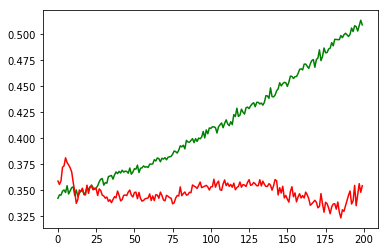

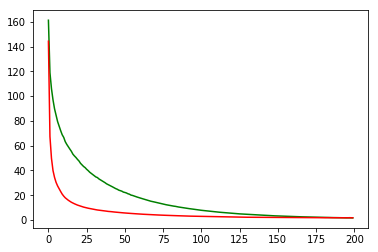

working on d,u and l,le 0.5 128 0.05 0.001


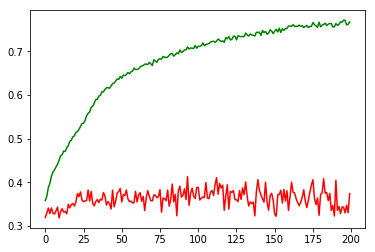

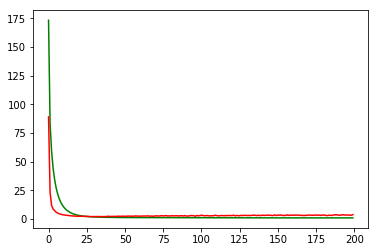

working on d,u and l,le 0.5 128 0.05 0.0001


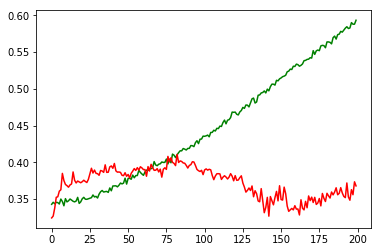

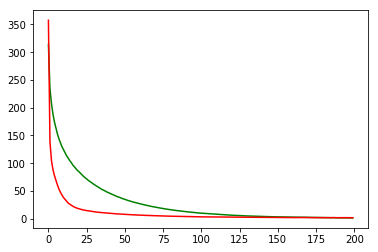

working on d,u and l,le 0.5 256 0.05 0.001


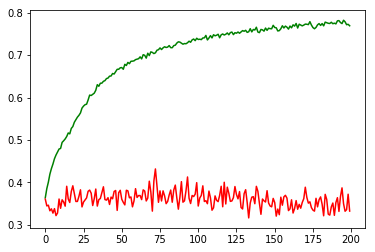

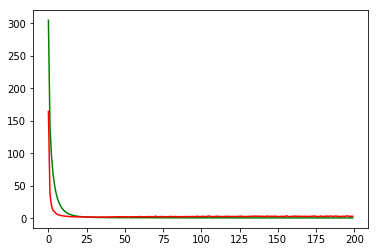

working on d,u and l,le 0.5 256 0.05 0.0001


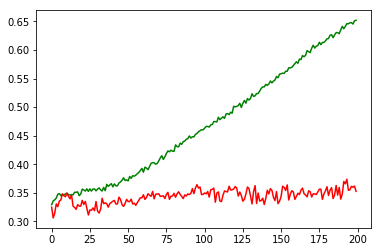

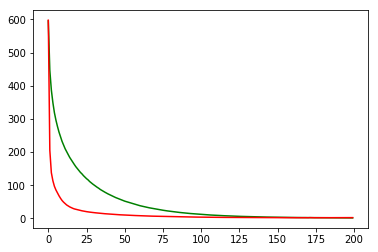

best model u,l,d,learn 0.05 64 0.5 0.001
Chart for BEST MODEL FOR: NVDA


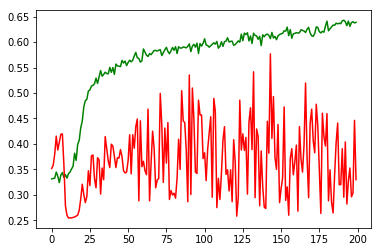

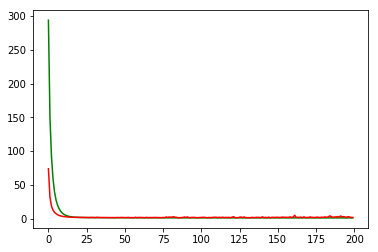

G-score: 0.5046235704142791
Accuracy 0.32950530182767673
0.3295053003533569
Window: 140
[[180  91  17]
 [212  93  15]
 [200 224 100]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... NFLX
14.669899702413757
0.00276273621394378
working on d,u and l,le 0.5 64 0.05 0.001


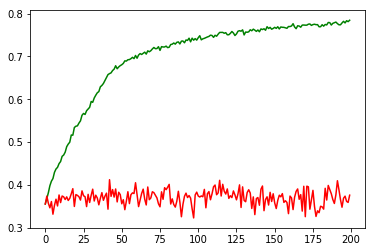

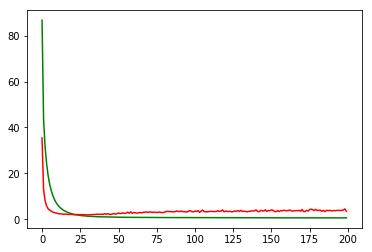

working on d,u and l,le 0.5 64 0.05 0.0001


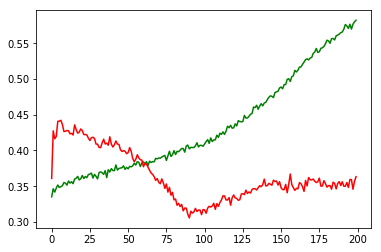

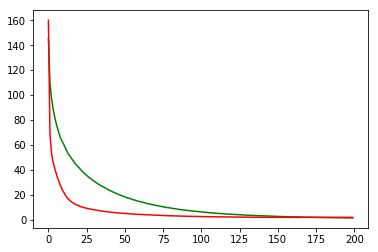

working on d,u and l,le 0.5 128 0.05 0.001


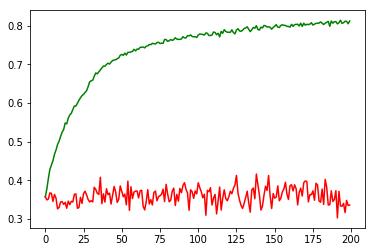

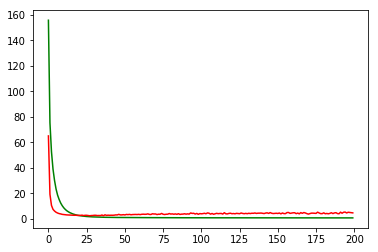

working on d,u and l,le 0.5 128 0.05 0.0001


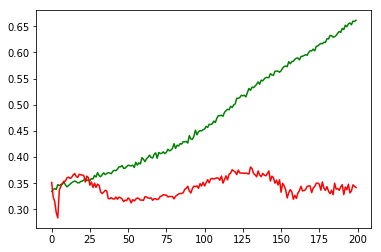

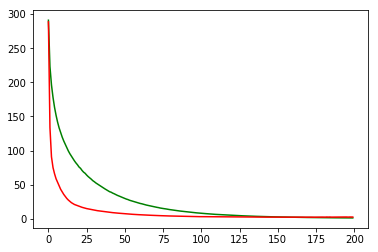

working on d,u and l,le 0.5 256 0.05 0.001


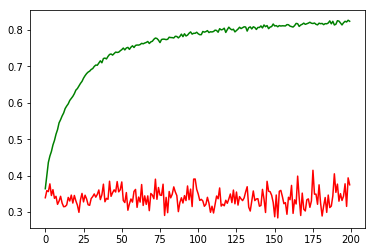

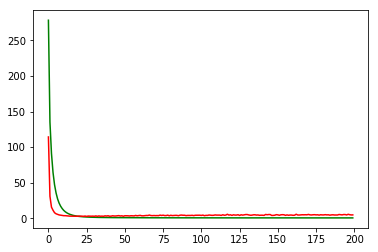

working on d,u and l,le 0.5 256 0.05 0.0001


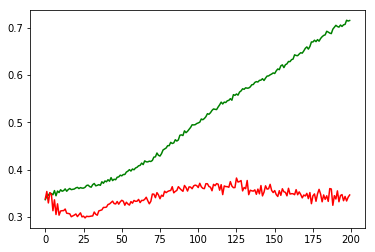

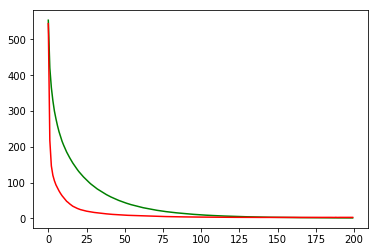

best model u,l,d,learn 0.05 64 0.5 0.001
Chart for BEST MODEL FOR: NFLX


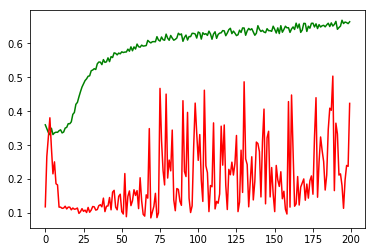

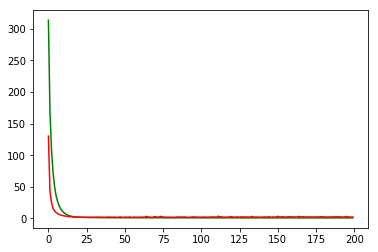

G-score: 0.4506138995428926
Accuracy 0.423144875693237
0.42314487632508835
Window: 140
[[  1  30  96]
 [ 70 117 242]
 [ 94 121 361]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... BKNG
3.9693863684895057
0.013598169405054938
working on d,u and l,le 0.5 64 0.05 0.001
Non balance
Non balance


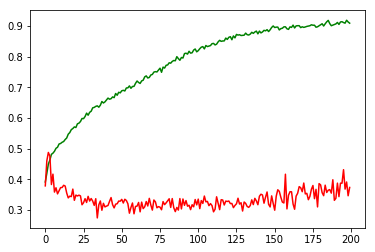

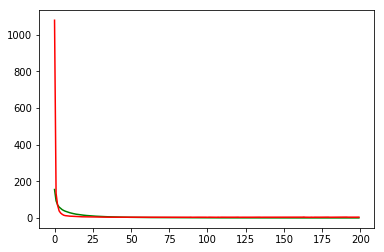

working on d,u and l,le 0.5 64 0.05 0.0001
Non balance
Non balance


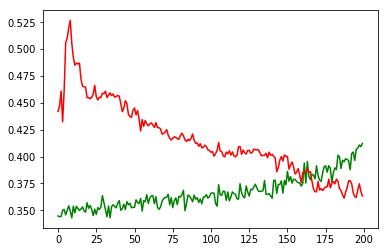

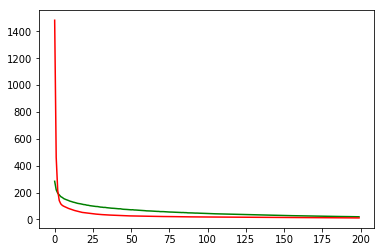

working on d,u and l,le 0.5 128 0.05 0.001
Non balance
Non balance


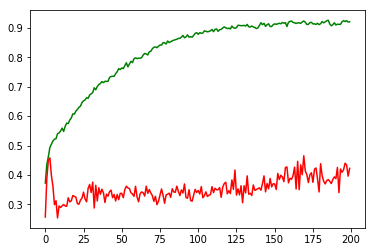

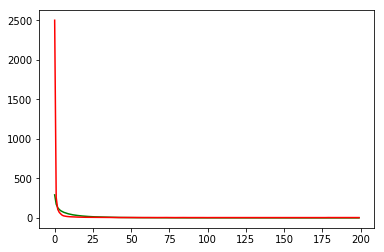

working on d,u and l,le 0.5 128 0.05 0.0001
Non balance
Non balance


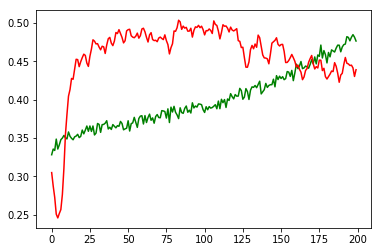

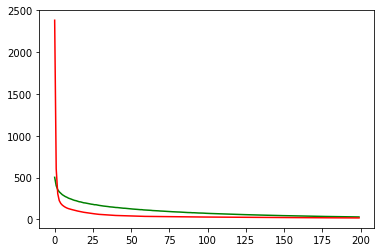

working on d,u and l,le 0.5 256 0.05 0.001
Non balance
Non balance


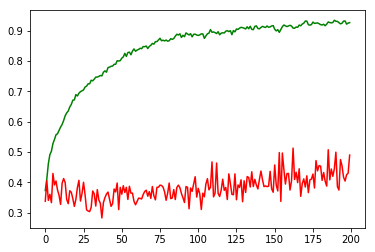

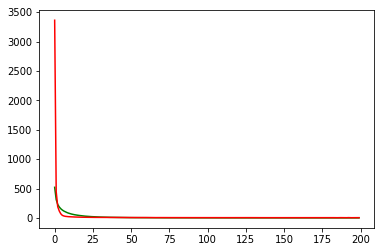

working on d,u and l,le 0.5 256 0.05 0.0001
Non balance
Non balance


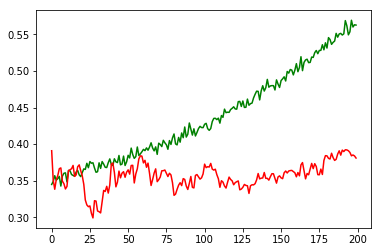

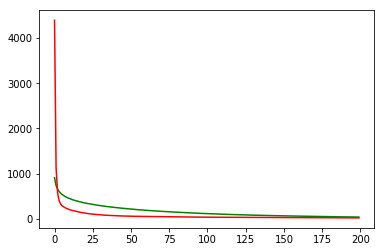

best model u,l,d,learn 0.05 128 0.5 0.001
Chart for BEST MODEL FOR: BKNG


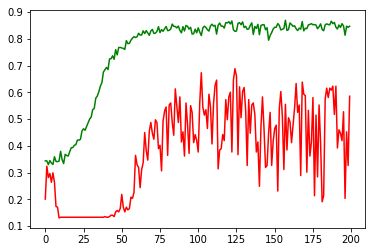

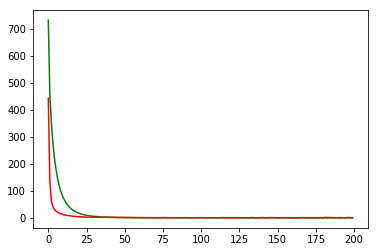

G-score: 0.5724700496132323
Accuracy 0.5854271350793503
0.585427135678392
Window: 140
[[  2  82  16]
 [  0  20  33]
 [  0  34 211]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... ADBE
9.949148290880911
0.0
working on d,u and l,le 0.5 64 0.05 0.001


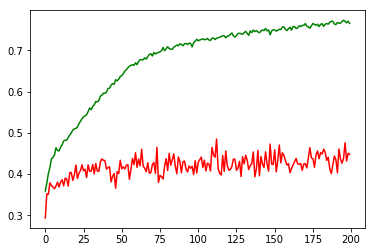

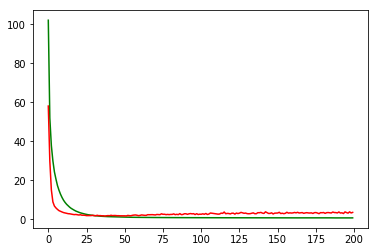

working on d,u and l,le 0.5 64 0.05 0.0001


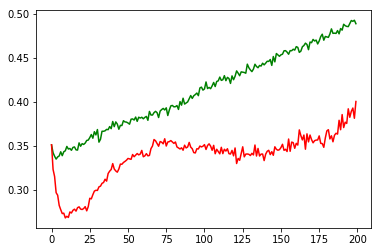

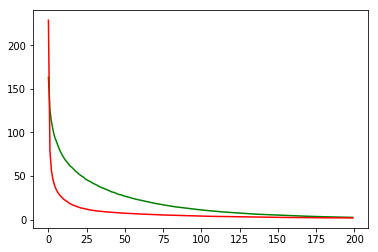

working on d,u and l,le 0.5 128 0.05 0.001


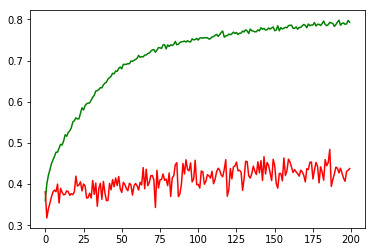

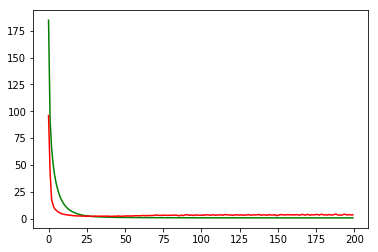

working on d,u and l,le 0.5 128 0.05 0.0001


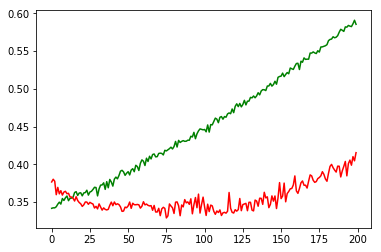

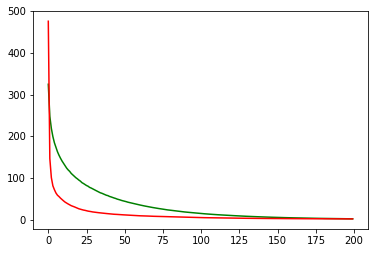

working on d,u and l,le 0.5 256 0.05 0.001


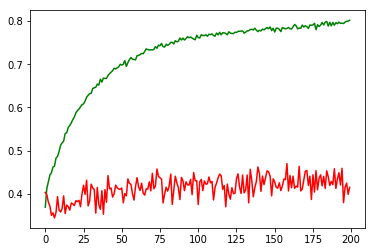

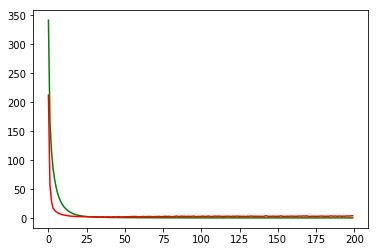

working on d,u and l,le 0.5 256 0.05 0.0001


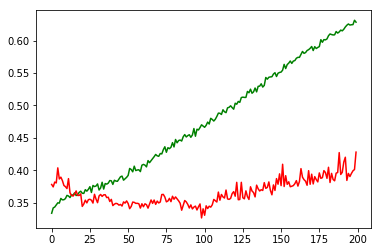

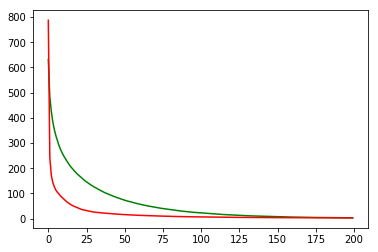

best model u,l,d,learn 0.05 64 0.5 0.001
Chart for BEST MODEL FOR: ADBE


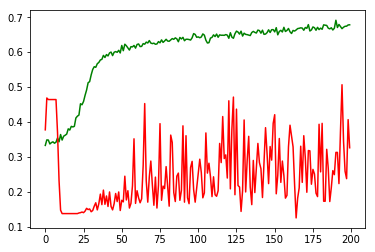

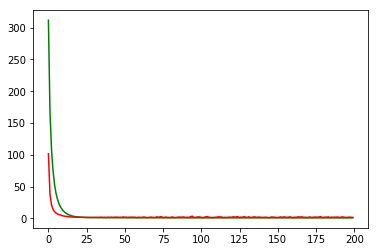

G-score: 0.4858614971279408
Accuracy 0.32595217275450566
0.3259521700620018
Window: 140
[[ 58  84  13]
 [153 286  11]
 [156 344  24]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... AMGN
6.235840507476206
0.0
working on d,u and l,le 0.5 64 0.05 0.001


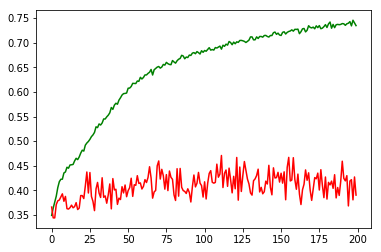

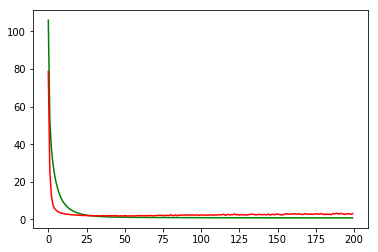

working on d,u and l,le 0.5 64 0.05 0.0001


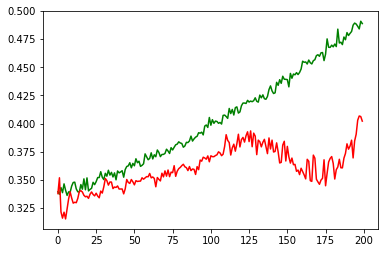

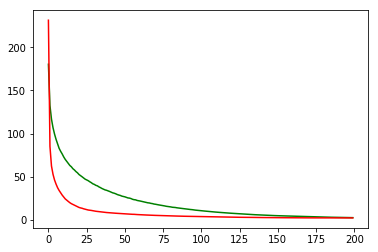

working on d,u and l,le 0.5 128 0.05 0.001


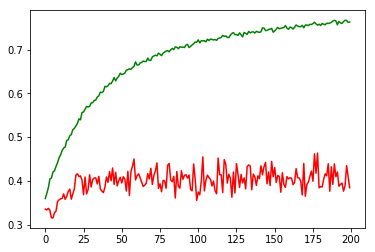

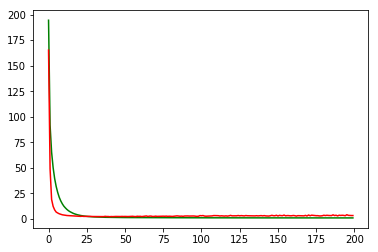

working on d,u and l,le 0.5 128 0.05 0.0001


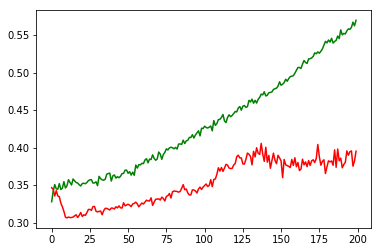

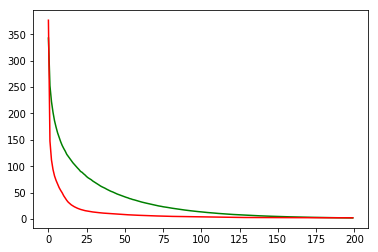

working on d,u and l,le 0.5 256 0.05 0.001


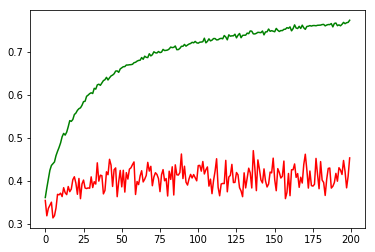

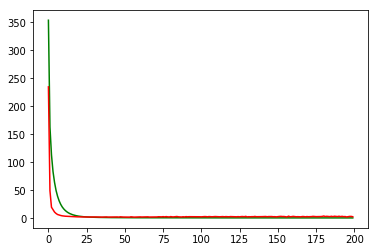

working on d,u and l,le 0.5 256 0.05 0.0001


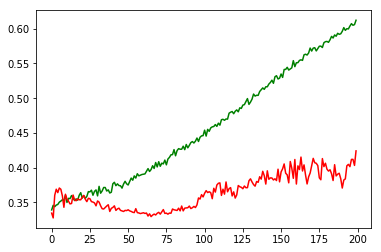

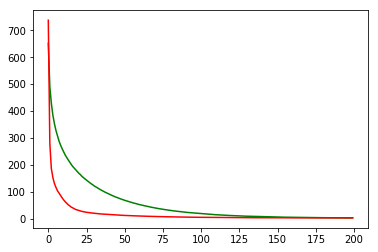

best model u,l,d,learn 0.05 256 0.5 0.001
Chart for BEST MODEL FOR: AMGN


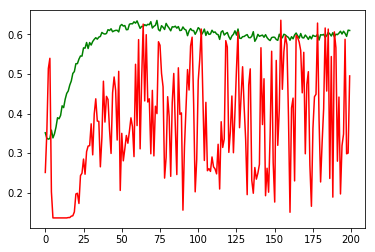

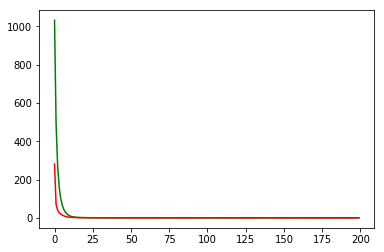

G-score: 0.5338124348426614
Accuracy 0.49510240451310855
0.4951024042742654
Window: 140
[[145   4  96]
 [ 97   6  50]
 [305  15 405]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... TXN
8.254787181267975
0.008754267705498472
working on d,u and l,le 0.5 64 0.05 0.001


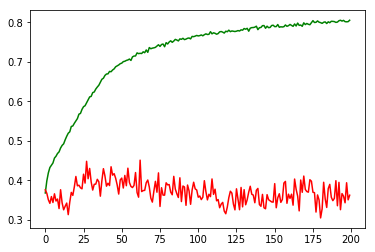

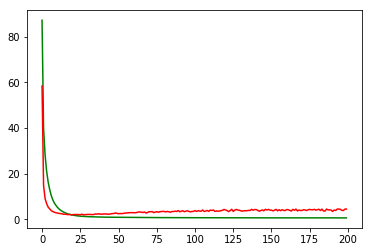

working on d,u and l,le 0.5 64 0.05 0.0001


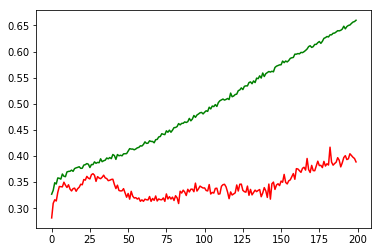

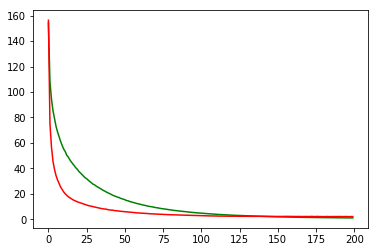

working on d,u and l,le 0.5 128 0.05 0.001


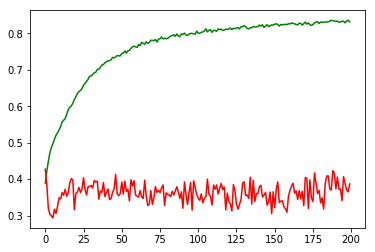

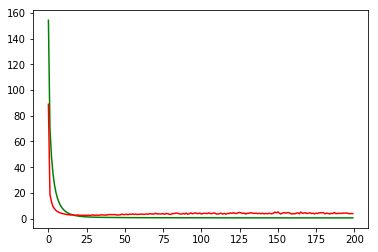

working on d,u and l,le 0.5 128 0.05 0.0001


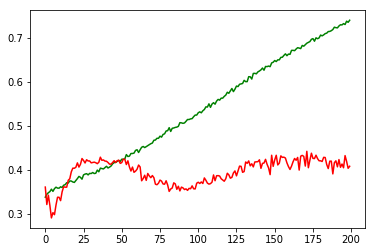

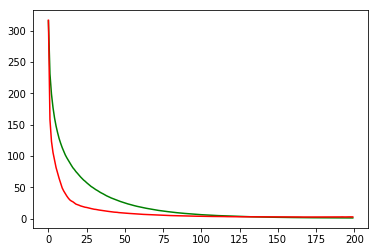

working on d,u and l,le 0.5 256 0.05 0.001


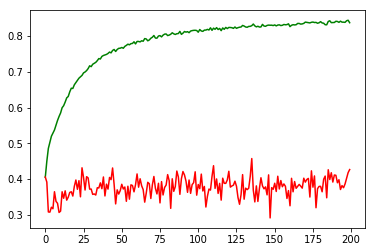

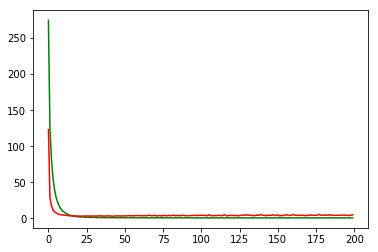

working on d,u and l,le 0.5 256 0.05 0.0001


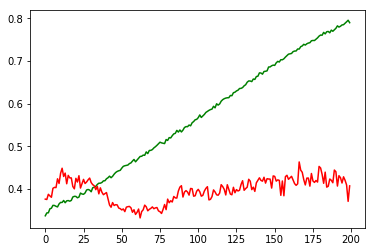

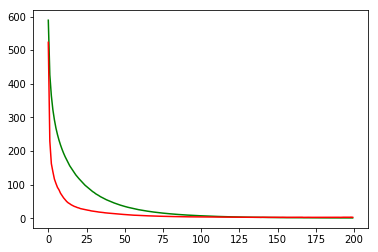

best model u,l,d,learn 0.05 256 0.5 0.001
Chart for BEST MODEL FOR: TXN


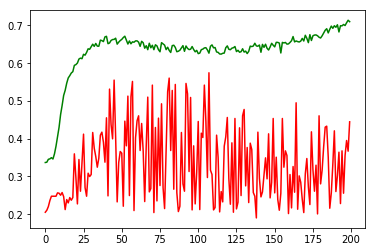

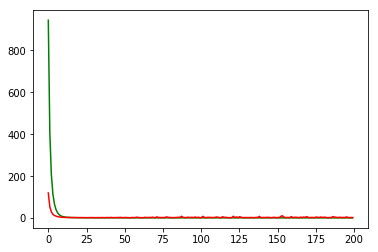

G-score: 0.557528636003991
Accuracy 0.44473916998381746
0.4447391688770999
Window: 140
[[158  15  57]
 [121  34 125]
 [152 158 311]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... AVGO
10.183057294555825
0.0
working on d,u and l,le 0.5 64 0.05 0.001


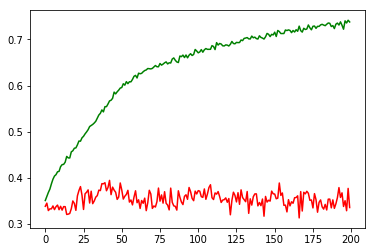

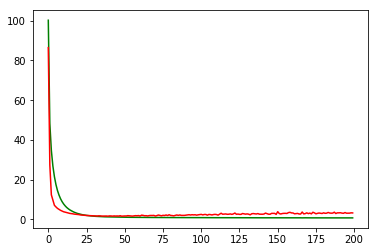

working on d,u and l,le 0.5 64 0.05 0.0001


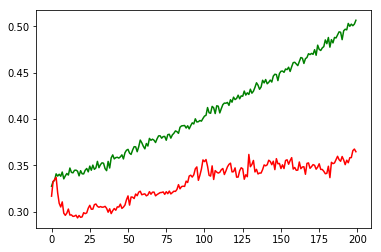

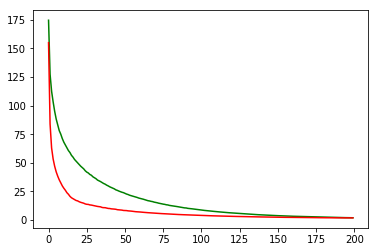

working on d,u and l,le 0.5 128 0.05 0.001


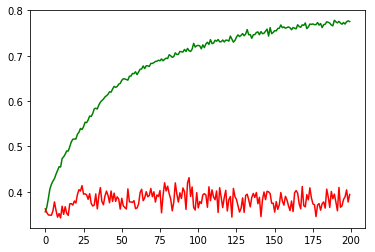

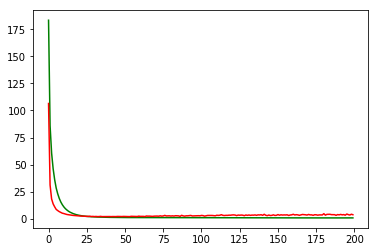

working on d,u and l,le 0.5 128 0.05 0.0001


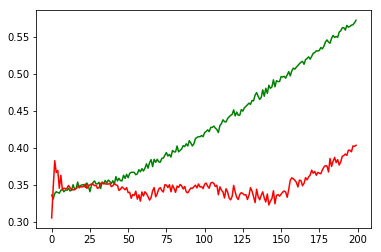

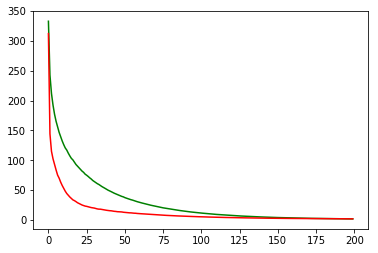

working on d,u and l,le 0.5 256 0.05 0.001


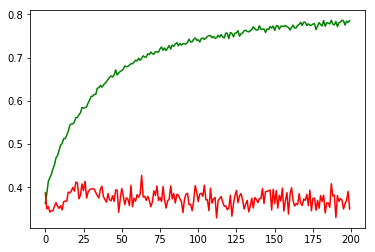

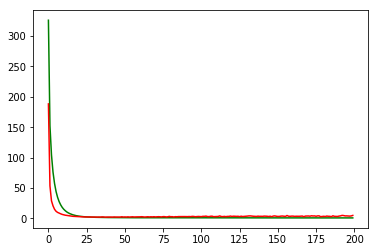

working on d,u and l,le 0.5 256 0.05 0.0001


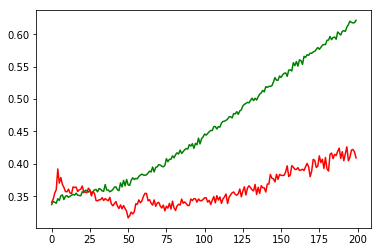

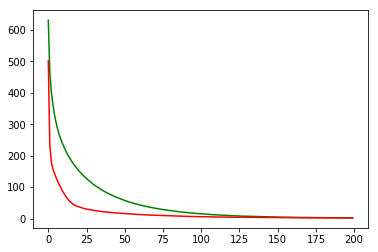

best model u,l,d,learn 0.05 256 0.5 0.0001
Chart for BEST MODEL FOR: AVGO


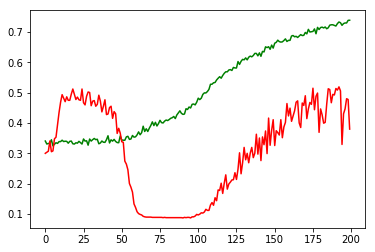

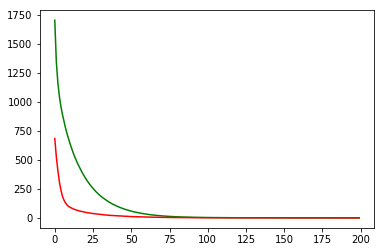

G-score: 0.5143763371840269
Accuracy 0.37976929878596194
0.3797692990239574
Window: 140
[[109 122 135]
 [ 42  43  13]
 [192 195 276]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... PYPL
12.136266855926186
0.0
working on d,u and l,le 0.5 64 0.05 0.001


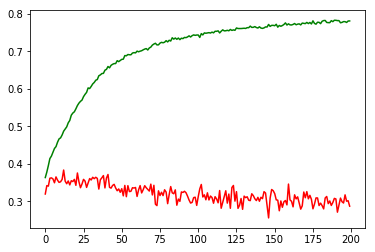

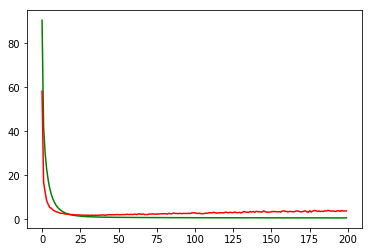

working on d,u and l,le 0.5 64 0.05 0.0001


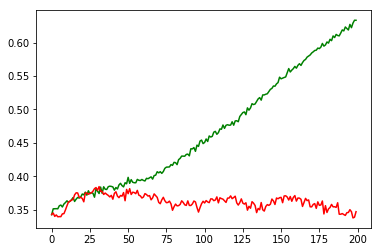

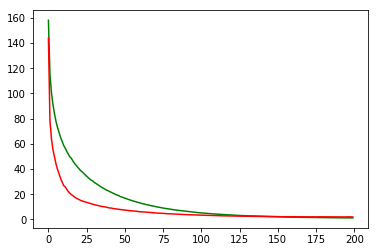

working on d,u and l,le 0.5 128 0.05 0.001


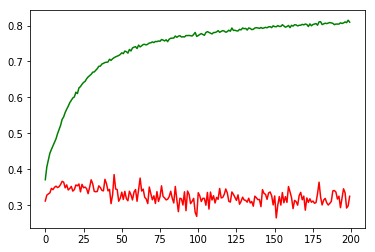

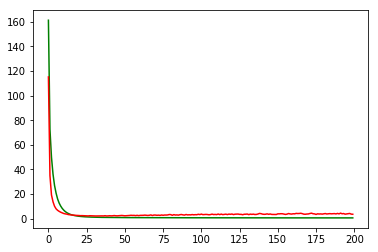

working on d,u and l,le 0.5 128 0.05 0.0001


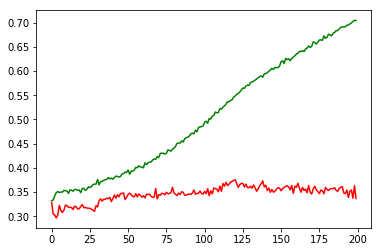

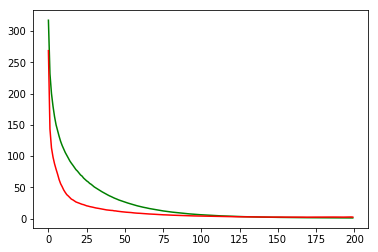

working on d,u and l,le 0.5 256 0.05 0.001


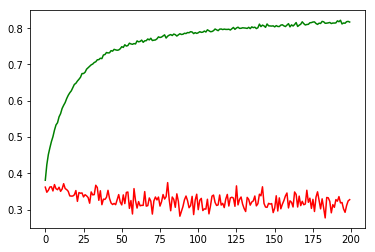

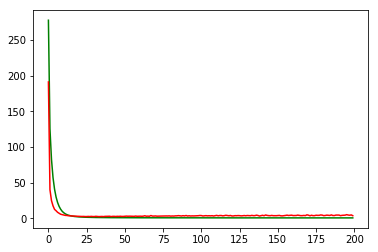

working on d,u and l,le 0.5 256 0.05 0.0001


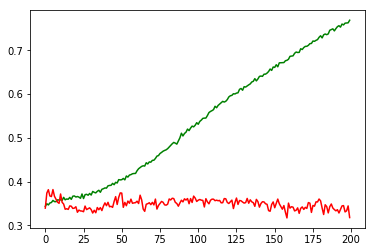

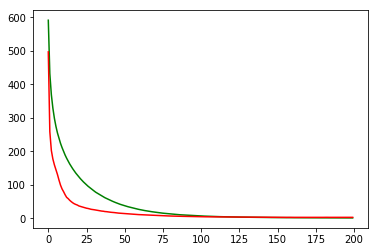

best model u,l,d,learn 0.05 64 0.5 0.0001
Chart for BEST MODEL FOR: PYPL


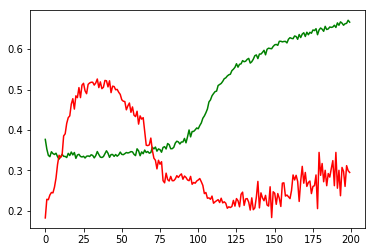

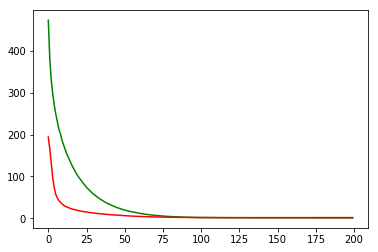

G-score: 0.43349036599079815
Accuracy 0.2949512848635497
0.2949512843224092
Window: 140
[[ 96  17 100]
 [158  25  89]
 [346  86 212]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... GILD
12.867944909532813
0.0
working on d,u and l,le 0.5 64 0.05 0.001


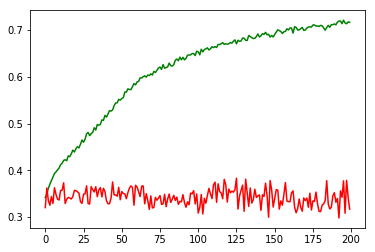

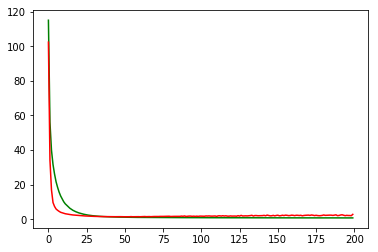

working on d,u and l,le 0.5 64 0.05 0.0001


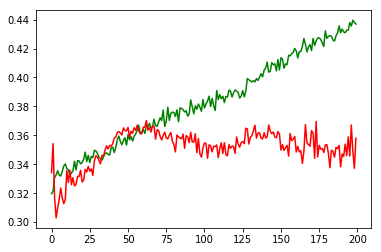

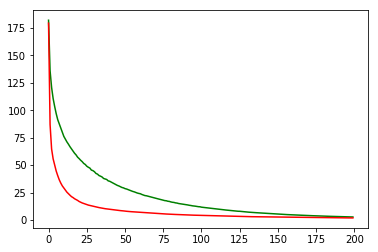

working on d,u and l,le 0.5 128 0.05 0.001


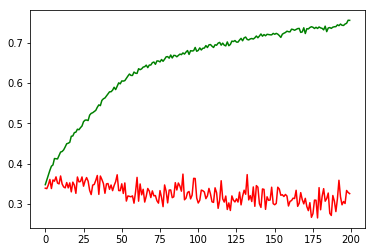

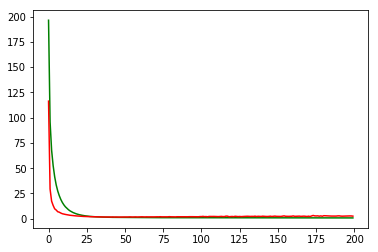

working on d,u and l,le 0.5 128 0.05 0.0001


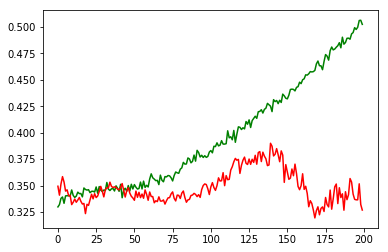

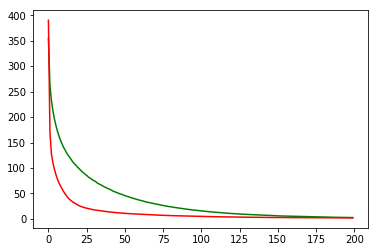

working on d,u and l,le 0.5 256 0.05 0.001


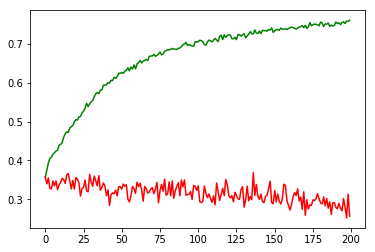

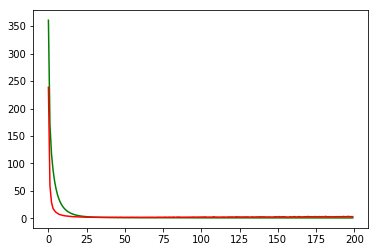

working on d,u and l,le 0.5 256 0.05 0.0001


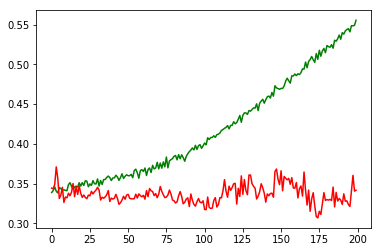

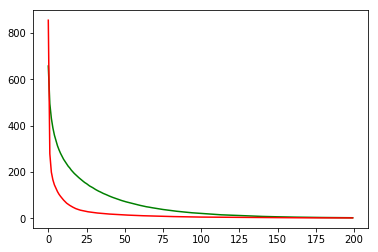

best model u,l,d,learn 0.05 64 0.5 0.0001
Chart for BEST MODEL FOR: GILD


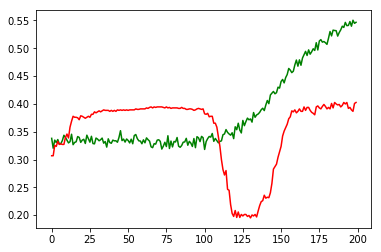

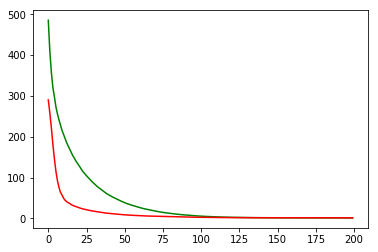

G-score: 0.49973929283160373
Accuracy 0.4024822695695974
0.4024822695035461
Window: 140
[[ 18 167 290]
 [  0  25 180]
 [  3  34 411]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... COST
4.088465050218121
0.001175434642521966
working on d,u and l,le 0.5 64 0.05 0.001


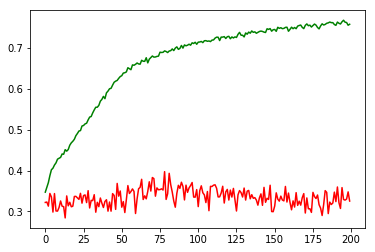

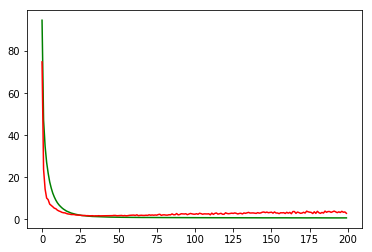

working on d,u and l,le 0.5 64 0.05 0.0001


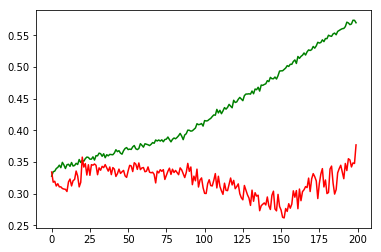

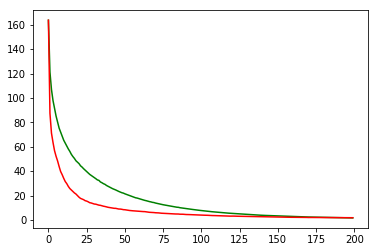

working on d,u and l,le 0.5 128 0.05 0.001


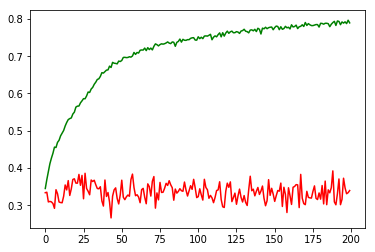

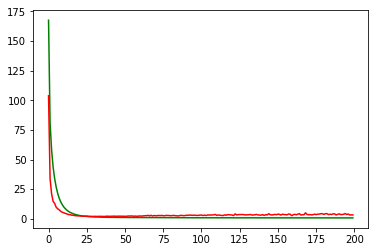

working on d,u and l,le 0.5 128 0.05 0.0001


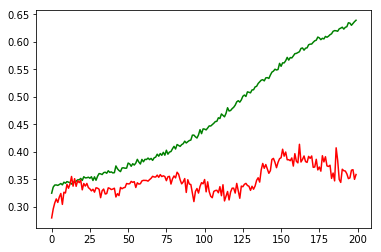

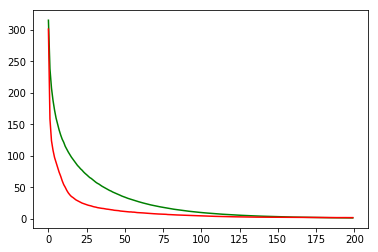

working on d,u and l,le 0.5 256 0.05 0.001


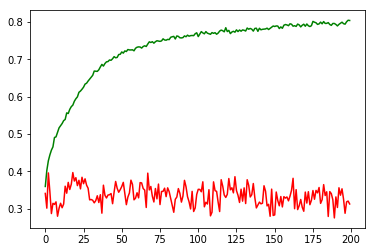

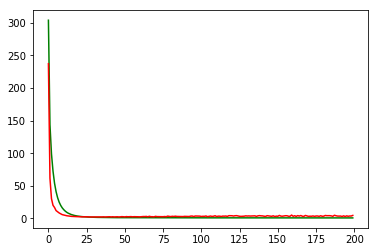

working on d,u and l,le 0.5 256 0.05 0.0001


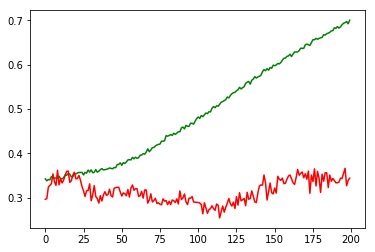

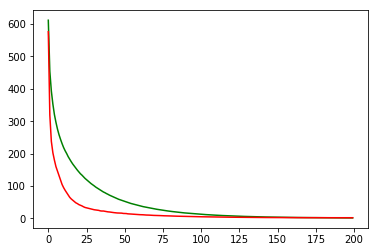

best model u,l,d,learn 0.05 64 0.5 0.0001
Chart for BEST MODEL FOR: COST


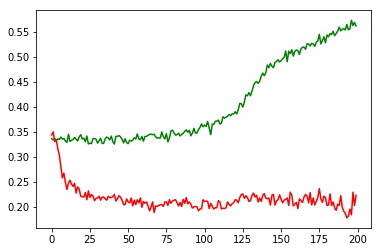

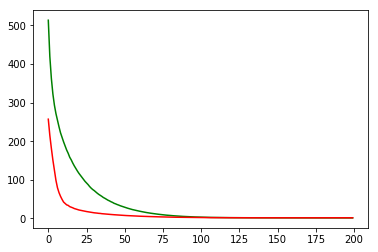

G-score: 0.4671877752453211
Accuracy 0.22360248457121448
0.2236024844720497
Window: 140
[[124  50   8]
 [282  94  21]
 [402 112  34]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... QCOM
11.725006748852696
0.0
working on d,u and l,le 0.5 64 0.05 0.001


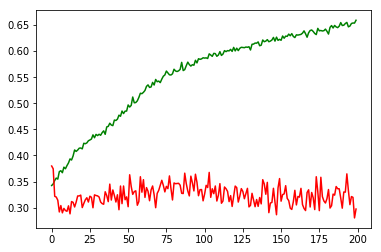

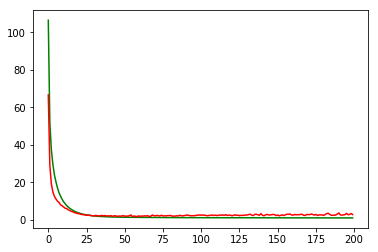

working on d,u and l,le 0.5 64 0.05 0.0001


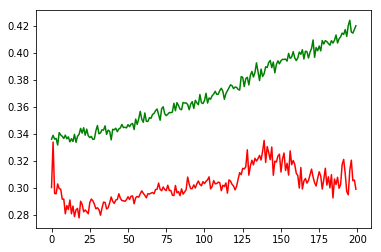

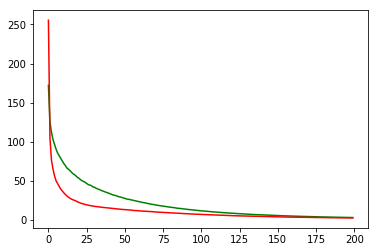

working on d,u and l,le 0.5 128 0.05 0.001


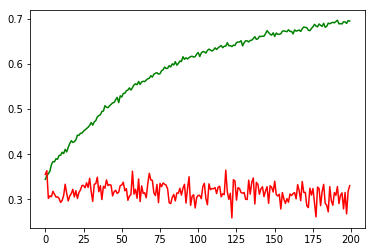

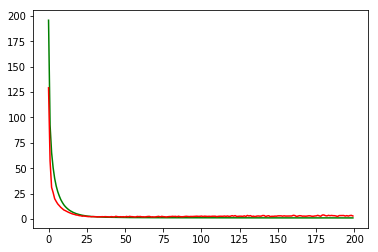

working on d,u and l,le 0.5 128 0.05 0.0001


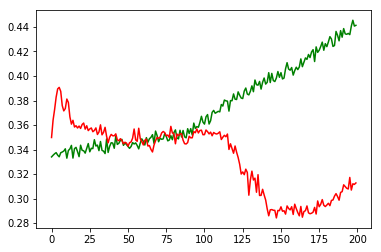

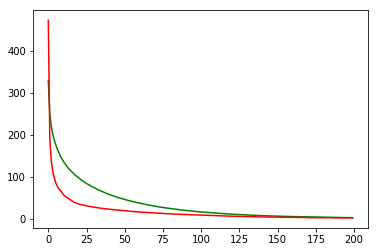

working on d,u and l,le 0.5 256 0.05 0.001


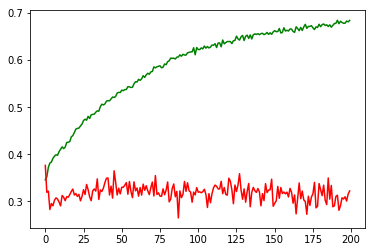

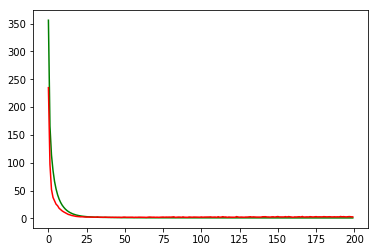

working on d,u and l,le 0.5 256 0.05 0.0001


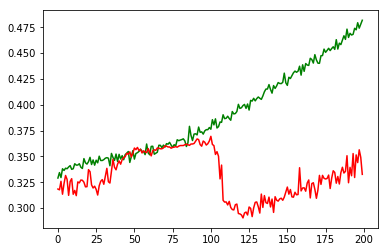

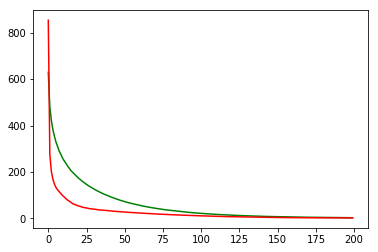

best model u,l,d,learn 0.05 128 0.5 0.001
Chart for BEST MODEL FOR: QCOM


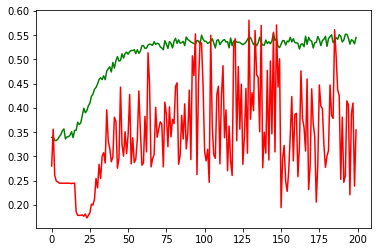

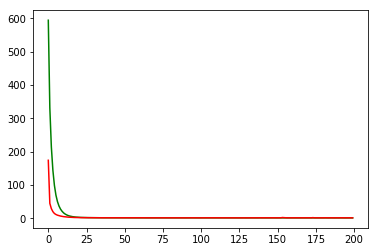

G-score: 0.5121555625769187
Accuracy 0.35455349258992863
0.35455349248452694
Window: 140
[[ 70 142  65]
 [ 28 110  64]
 [ 36 395 221]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Mean acc over portfolio: 0.37618802405865237


In [9]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
o=0
accstocksresults=[]
f1stocksresults=[]
f1scoreresults=[]
aucresults=[]
chartlist=[]
gainlist=[]
pricegainlist=[]

for price in prices:
    #print('New price[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]')
    
   
    print('Working on...',files[o])
    
    senttemp=sentiment[o]
    senttemp=np.nan_to_num(np.asarray(senttemp, dtype=float))
    
    xtemp=price
    o+=1
    xtemp=np.nan_to_num(np.asarray(xtemp, dtype=float))
    
    #print(xtemp)
    accintime=[]
    trendwindowtime=[140]
    f1total=[]
    acctotal=[]
    auctotal=[]
    percfinal=[]
    f1scoretotal=[]
    percpostotal=[]
    percnegtotal=[]
    for t in trendwindowtime:
        #1
    #label because of the maket and append values without data
    #simo theroy past trend
        
        x=[]
        y=[]
        
        percentage=[]
        
        yvolatility=[]
        yprice=[]
        #print('============================================================')
        #print('Working on window:',t)
        #print(len(xtemp))
        ##QUI C E L'UNICO APPUNTO GUARDA SE CON +1 CAMBIA
        
        for i in range(0,len(price)-t-1):
            yvolatility.append((100*abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open'])
        
        minref=min(yvolatility)
        
        std=np.std(price['close'])
        mprice=np.mean(price['close'])
        
        step=((100*std)/mprice)*0.1
        
        for i in range(0,len(price)-t-1):
            s=np.sign(price.iloc[i+t+1]['close']-price.iloc[i+1]['open'])
            delta=abs((100*(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open'])
            percentage.append((100*(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open']) 
            if(delta<=minref+step):
                
                y.append(0)
            else:
                if(s==-1):
                    
                    y.append(-1)
                elif(s==1):
                    
                    y.append(1)
                else:
                    print('problem in labeling')
                
            
            yprice.append(abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))
            x.append(np.concatenate((senttemp[i],xtemp[i])))
        
        y=np.array(y)
        x=np.array(x)
        scaler = MinMaxScaler() 
        scaler.fit(x)
        MinMaxScaler(copy=True, feature_range=(0, 1))
        x=scaler.transform(x)
        yvolatility=np.array(yvolatility)
       
        permindex=range(0,len(x))
        #permindex=np.random.permutation(permindex)
        train=0.8
        nt=math.ceil(len(x)*train)
        trainvalindex=permindex[0:nt]
        testindex=permindex[nt:]
        x_tv=[]
        y_tv=[]
        x_test=[]
        y_test=[]
        x_tv=x[trainvalindex]
        y_tv=y[trainvalindex]
        x_test=x[testindex]
        y_test=y[testindex]
        yvolatilitytest=yvolatility[testindex]
        #create structure for percentile valuation
        distribution=[]
        print(max(yvolatilitytest))
        print(min(yvolatilitytest))
        step=(max(yvolatilitytest)-min(yvolatilitytest))/5
        for v in range(0,5):
            pindexes=[]
            for r in range(0,len(y_test)):
                if(yvolatilitytest[r]<min(yvolatilitytest)+step+step*v and yvolatilitytest[r]>min(yvolatilitytest)+step*v):
                    pindexes.append(r)
            distribution.append(pindexes)
    

        #learnspace=[0.01,0.005,0.001,0.0005,0.0001]
        #lspace=[0.05,0.01]
        #dropspace=[0,0.5]
        #uspace=[64,128]
        learnspace=[0.001,0.0001]
        lspace=[0.05]
        dropspace=[0.5]
        uspace=[64,128,256]
        bestsvm=None
        bestca=[]
        bestcl=[]
        maxacc=0
        cvacc=0
        maxd=0
        maxu=0
        maxl=0
        maxle=0
        #print('Model Selection...')
        #model selection
        cvacc=0
        totu=0
        for d in dropspace:
            for u in uspace:
                
                for l in lspace:
                    for le in learnspace:
                    
                   
                        print('=========================================================')
                        print('working on d,u and l,le',d,u,l,le)

                        cvacclist=[]
                        #faccio cross validation
                        #start with 40% as train and 10% for validation and then i move in percentege
                        # 0-40 40-50
                        # 0-50 50-60
                        # 0-60 60-70 
                        #etc test set is completely external i do in some way error extimation changin the ticker
                        trainpoint=math.floor(len(x_tv)*0.40)
                        dimval=math.floor(trainpoint*0.25)
                        endval=trainpoint+dimval
                        model=buildModel(l,u,d,le)
                        for i in range(0,6):
                            #print('-----')
                            x_train=x_tv[0:trainpoint]
                            y_train=y_tv[0:trainpoint]
                            x_val=x_tv[trainpoint:endval]
                            y_val=y_tv[trainpoint:endval]

                            trainpoint=trainpoint+dimval
                            endval=endval+dimval

                            
                            try:
                                x_train,y_train=smote(x_train,y_train)
                                x_val,y_val=smote(x_val,y_val)
                            except:
                                print('Non balance')

                            history=model.fit(x_train, np.array(toOneHot(y_train)), epochs = 200,batch_size =128, verbose=0, validation_data=(x_val, np.array(toOneHot(y_val))),
                                              shuffle=True)
                            predictionhot=model.predict(x_val, batch_size=128, verbose=0)

                            prediction=np.zeros(len(predictionhot))

                            for el in range(0,len(predictionhot)):
                                m=np.argmax(predictionhot[el])

                                if(m==2):
                                    prediction[el]=1
                                elif(m==0):
                                    prediction[el]=-1
                                else:
                                    prediction[el]=0



                            if(i==0):
                                meanhvl=np.asarray(history.history['val_loss'])
                                meanhva=np.asarray(history.history['val_acc'])
                                meanhl=np.asarray(history.history['loss'])
                                meanha=np.asarray(history.history['acc'])

                            else:
                                meanhvl=np.add(meanhvl,history.history['val_loss'])
                                meanhva=np.add(meanhva,history.history['val_acc'])
                                meanha=np.add(meanha,history.history['acc'])
                                meanhl=np.add(meanhl,history.history['loss'])
                            #i take the last one
                            #maxAcc=history.history['val_acc'][len(history.history['val_acc'])-1]
                            #USING G SCORE AS MODEL SELECTION METRIC


                            maxAcc=geometric_mean_score(y_val, prediction,labels=[0,1,-1],average='macro')

                            cvacclist.append(maxAcc)
                            reset_weights(model)

                        cvacc=sum(cvacclist)/len(cvacclist)
                        if(cvacc>maxacc):
                            maxacc=cvacc
                            maxu=u
                            maxl=l
                            maxle=le
                            maxd=d


                        meanhvl=meanhvl/6
                        meanhva=meanhva/6
                        meanhl=meanhl/6
                        meanha=meanha/6

                        plt.plot(meanha,'g')
                        plt.plot(meanhva,'r')
                        plt.show()
                        plt.plot(meanhl,'g')
                        plt.plot(meanhvl,'r')
                        plt.show()

                        print('=========================================================')
        print('best model u,l,d,learn',maxl,maxu,maxd,maxle)
        model=buildModel(maxl,maxu,maxd,maxle)
        x_tv,y_tv=smote(x_tv,y_tv)
        history=model.fit(x_tv, np.array(toOneHot(y_tv)), epochs = 200,batch_size =128, verbose=0, validation_data=(x_test, np.array(toOneHot(y_test))),shuffle=True)
        predictionhot=model.predict(x_test, batch_size=128, verbose=0)
        prediction=np.zeros(len(predictionhot))
        for el in range(0,len(predictionhot)):
            m=np.argmax(predictionhot[el])
            if(m==2):
                prediction[el]=1
            elif(m==0):
                prediction[el]=-1
            else:
                prediction[el]=0
            
        
        
        print('=========================================================')
        print('=========================================================')
        print('=========================================================')
        print('=========================================================')
        print('Chart for BEST MODEL FOR:',files[o-1])
        plt.plot(history.history['acc'],'g')
        plt.plot(history.history['val_acc'],'r')
        plt.show()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        plt.show()
        acctotal.append(history.history['val_acc'][len(history.history['val_acc'])-1])
        confmatrix=confusion_matrix(y_test, prediction)
        
        volr=[]
        voln=[]
        pricegain=0
        for j in range(0,len(x_test)):
            if(prediction[j]==0):
                bho=0
            elif(y_test[j]==prediction[j]):
                volr.append(yvolatilitytest[j])
                pricegain=pricegain+yprice[j]
            else:
                voln.append(yvolatilitytest[j])
                pricegain=pricegain-yprice[j]
        
        
        #fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        #auc=metrics.auc(fpr, tpr)
        valueacc=geometric_mean_score(y_test, prediction,labels=[0,1,-1],average='macro')
        
       
        print('G-score:',valueacc)
        temp=0
        for r in range(0,len(prediction)):
            if(y_test[r]==prediction[r]):
                temp+=1
        
         
        realacc=history.history['val_acc'][len(history.history['val_acc'])-1]
        accstocksresults.append(realacc)
        print('Accuracy',realacc)
        print(temp/len(prediction))  
        print('Window:',t)
        print(confmatrix)
      
        print('000000000000000000000000000000000000000000000000')
        #performances for each percentile
        chartscore=[]
        
        print('000000000000000000000000000000000000000000000000')
print('Mean acc over portfolio:',sum(accstocksresults)/len(accstocksresults))

#print all the accuracy varing the percentile
for st in range(0,len(chartlist)):
    plt.plot(chartlist[st])
plt.show()
        
